In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
from keras import layers
import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import cv2
import math

In [ ]:
# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 50

In [ ]:
def read_json(jsonPath):
	# open the json file
	with open(jsonPath, "r") as fp:
		# read the json data
		data = json.load(fp)

	# return the data
	return data

def get_image_c2w(jsonData, datasetPath):
	# define a list to store the image paths
	imagePaths = []

	# define a list to store the camera2world matrices
	c2ws = []
	# iterate over each frame of the data
	for frame in jsonData["frames"]:
		# grab the image file name
		imagePath = frame["file_path"]
		#imagePath = imagePath.replace(".", datasetPath)
		imagePaths.append(f"{imagePath}")
		# grab the camera2world matrix
		c2ws.append(frame["transform_matrix"])

	# return the image file names and the camera2world matrices
	return (imagePaths, c2ws)

In [ ]:
jsonData = read_json('transforms.json')

In [ ]:
ImagePaths, C2Ws = get_image_c2w(jsonData=jsonData,
	datasetPath='')

In [ ]:
ImagePaths[0]

'./newfruit_small/IMG_3636.jpg'

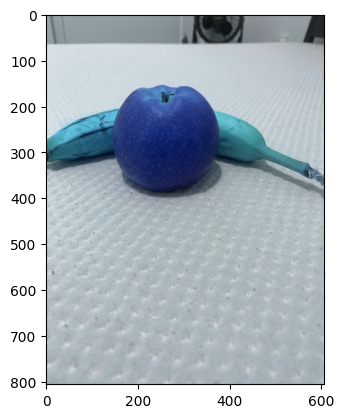

In [ ]:
img=cv2.imread(ImagePaths[0]).astype(np.float32)/255.0
plt.imshow(img)

In [ ]:
images=[]
for i in range(len(ImagePaths)):
  images.append(cv2.resize(cv2.cvtColor(cv2.imread(ImagePaths[i]), cv2.COLOR_BGR2RGB), (75,100), interpolation=cv2.INTER_AREA))
images=np.asarray(images).astype(np.float32)/255.0

In [ ]:
poses=np.asarray(C2Ws).astype(np.float32)

In [ ]:
focal=(images.shape[2]/2)/math.tan(jsonData['camera_angle_x']/2)

In [ ]:
(num_images, H, W, _) = images.shape

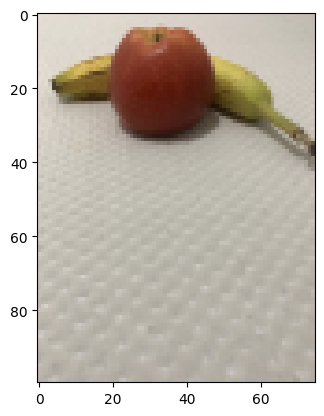

In [ ]:
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [ ]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)

def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

In [ ]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [ ]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

In [ ]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays
loss_list = []

In [ ]:
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

In [ ]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

In [ ]:
model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

In [ ]:
# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

Epoch 1/50
1/1 [==============================] - 1s 993ms/step


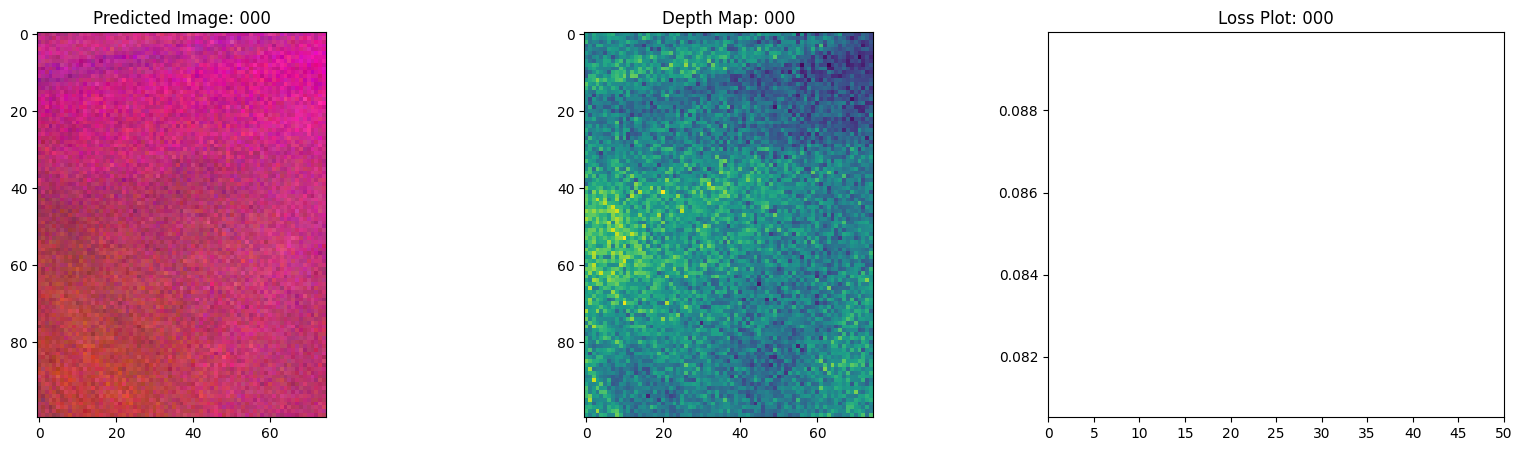

12/12 [==============================] - 26s 1s/step - loss: 0.0852 - psnr: 12.2791 - val_loss: 0.0281 - val_psnr: 15.5979
Epoch 2/50
1/1 [==============================] - 1s 569ms/step


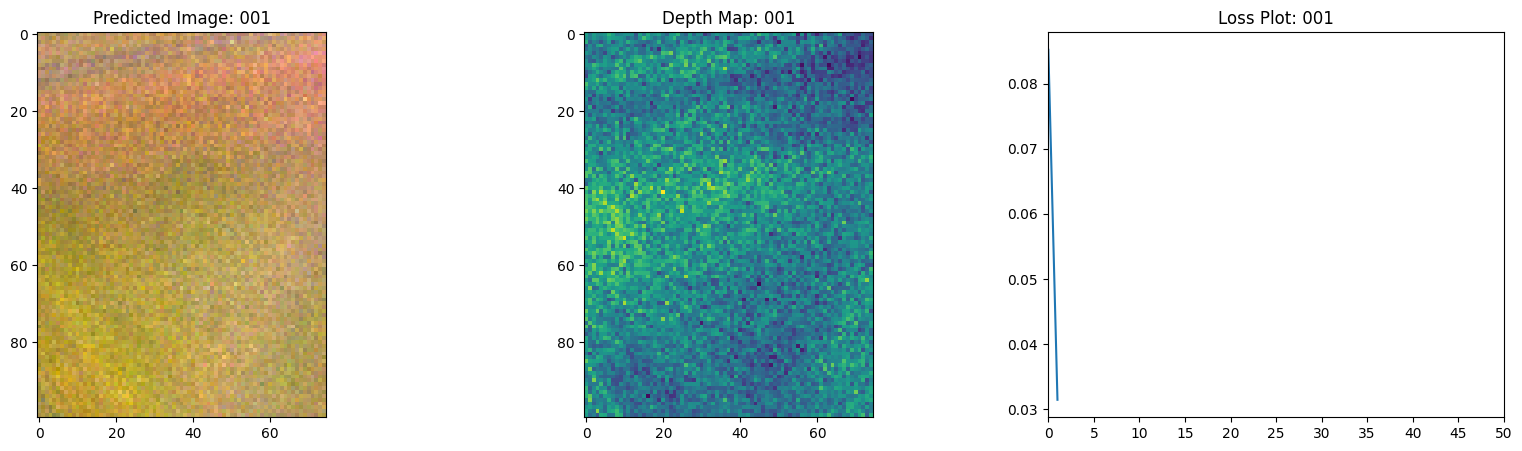

12/12 [==============================] - 22s 2s/step - loss: 0.0314 - psnr: 15.1887 - val_loss: 0.0233 - val_psnr: 16.4583
Epoch 3/50
1/1 [==============================] - 1s 555ms/step


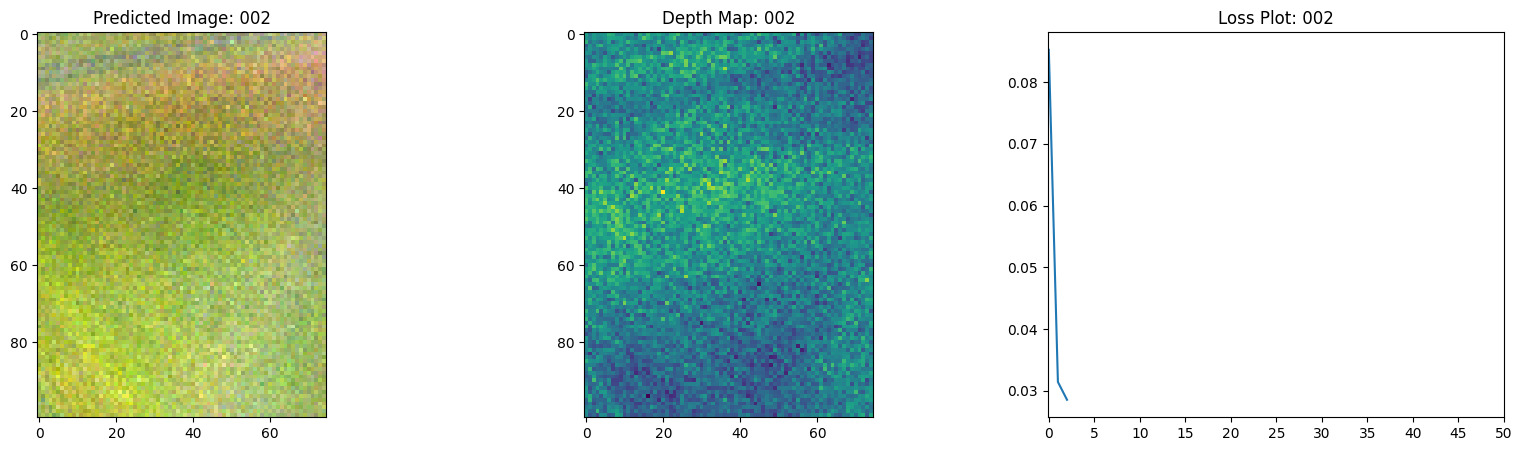

12/12 [==============================] - 23s 2s/step - loss: 0.0286 - psnr: 15.6241 - val_loss: 0.0223 - val_psnr: 16.6775
Epoch 4/50
1/1 [==============================] - 1s 645ms/step


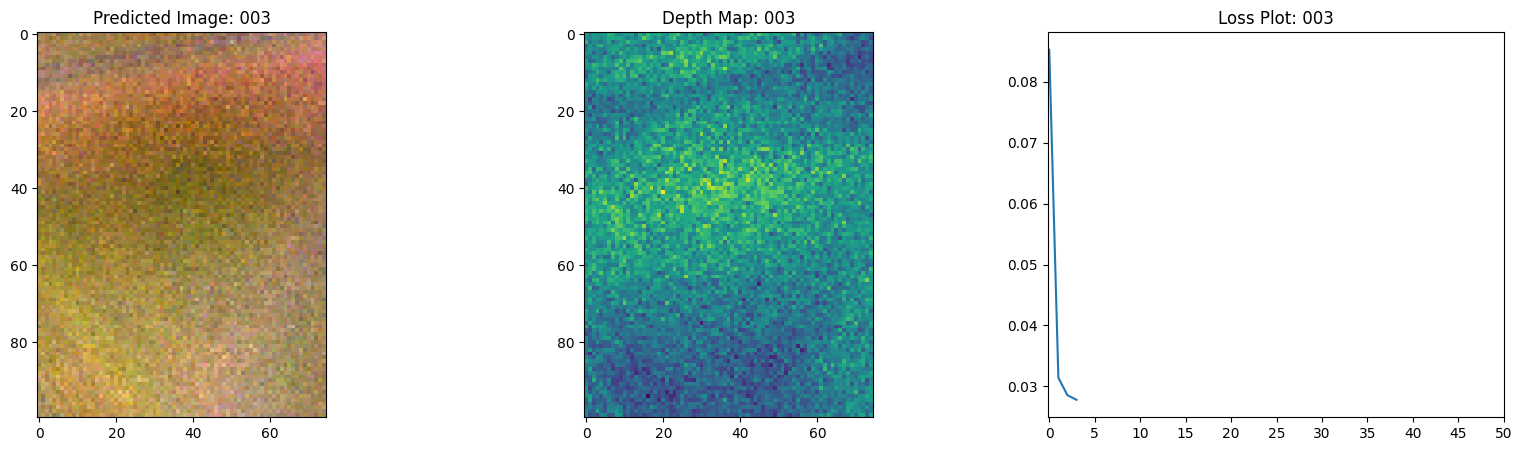

12/12 [==============================] - 23s 2s/step - loss: 0.0278 - psnr: 15.7517 - val_loss: 0.0207 - val_psnr: 16.9697
Epoch 5/50
1/1 [==============================] - 1s 557ms/step


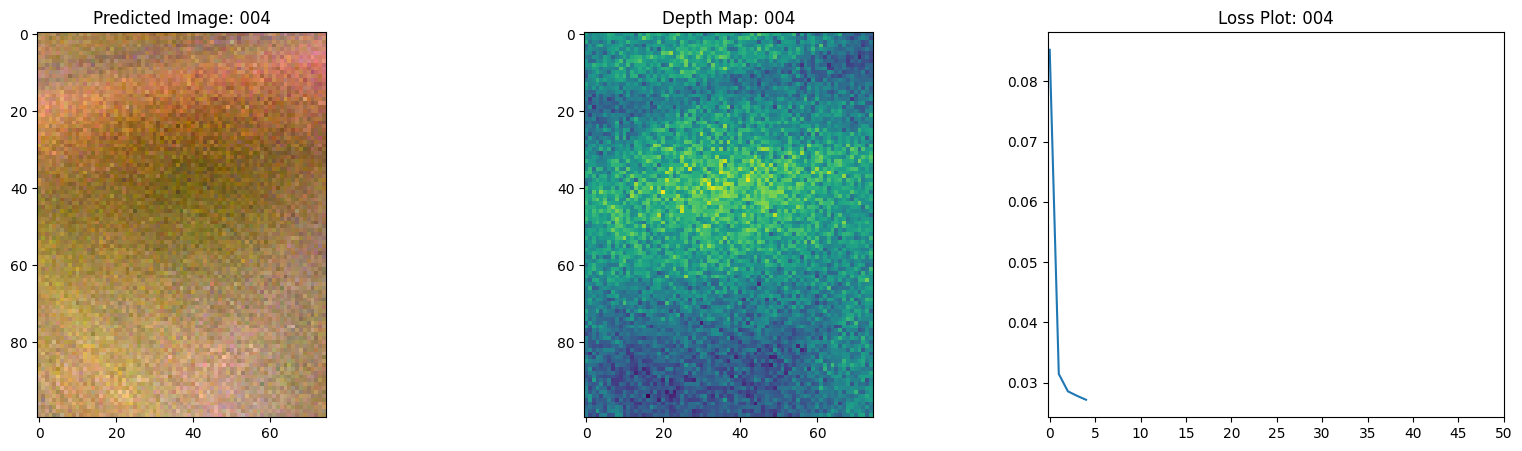

12/12 [==============================] - 22s 2s/step - loss: 0.0272 - psnr: 15.8280 - val_loss: 0.0211 - val_psnr: 16.8843
Epoch 6/50
1/1 [==============================] - 1s 677ms/step


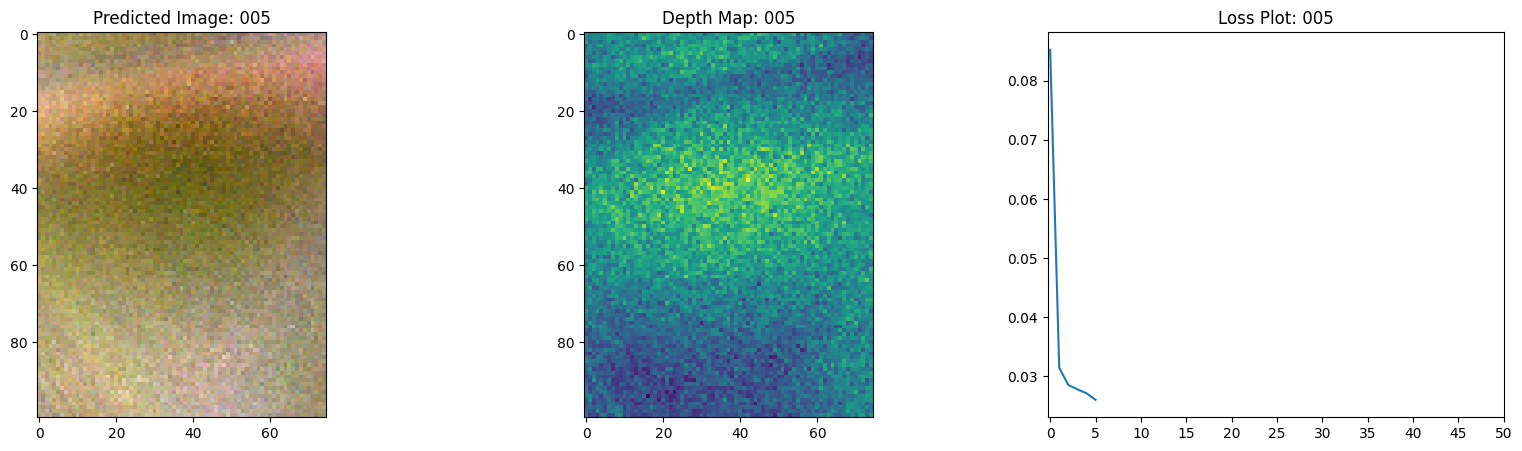

12/12 [==============================] - 23s 2s/step - loss: 0.0261 - psnr: 16.0006 - val_loss: 0.0198 - val_psnr: 17.1445
Epoch 7/50
1/1 [==============================] - 1s 558ms/step


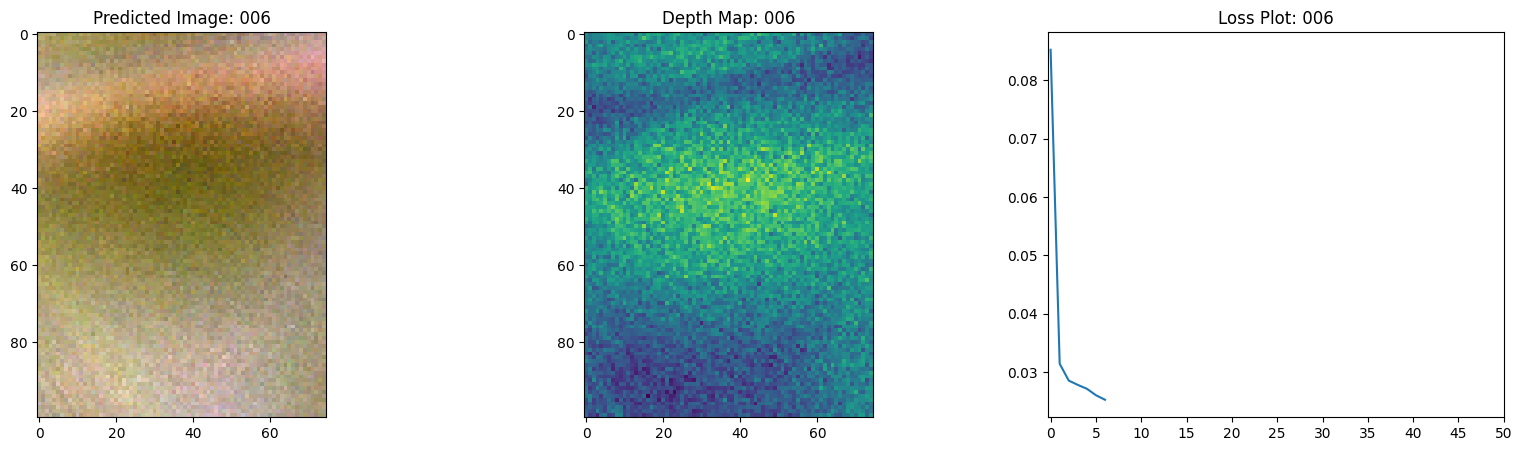

12/12 [==============================] - 23s 2s/step - loss: 0.0253 - psnr: 16.0986 - val_loss: 0.0198 - val_psnr: 17.1468
Epoch 8/50
1/1 [==============================] - 1s 573ms/step


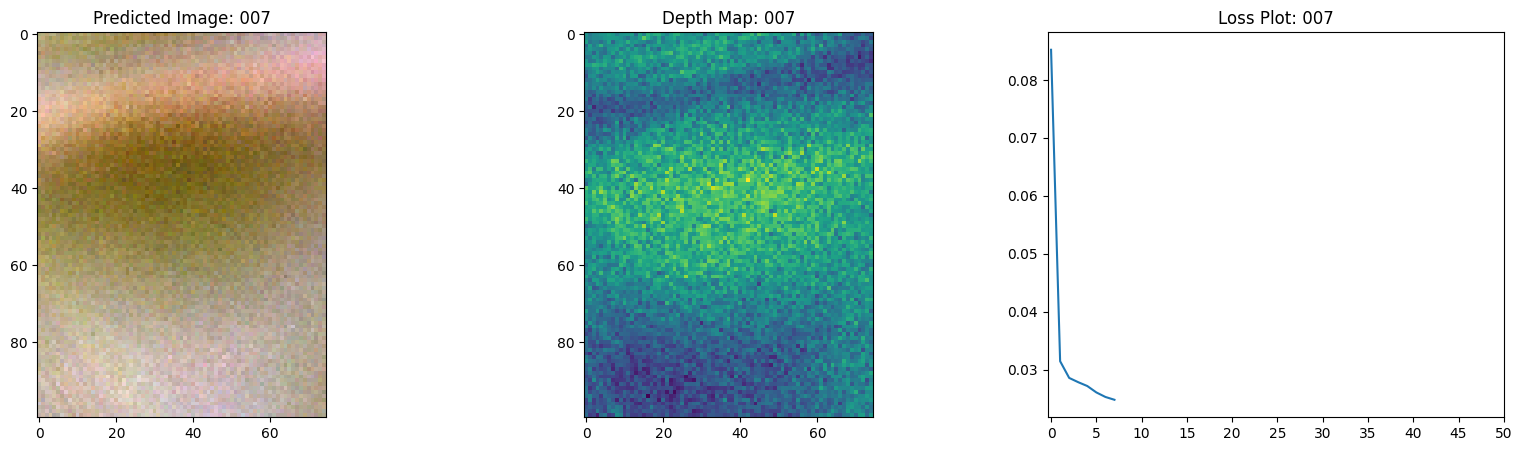

12/12 [==============================] - 23s 2s/step - loss: 0.0248 - psnr: 16.1648 - val_loss: 0.0200 - val_psnr: 17.0719
Epoch 9/50
1/1 [==============================] - 1s 557ms/step


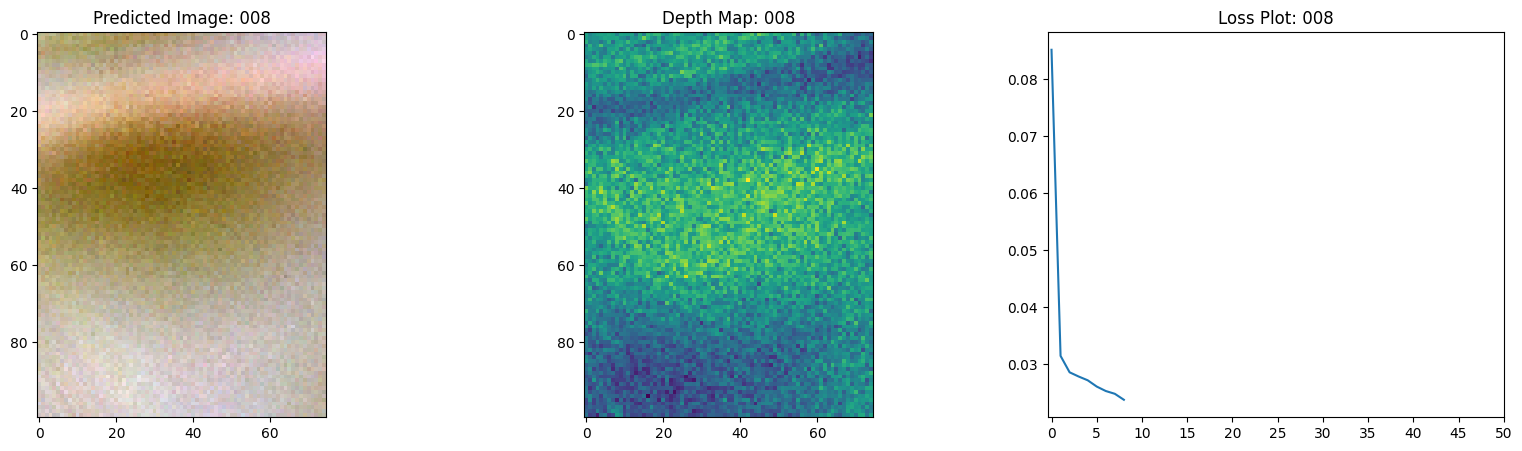

12/12 [==============================] - 22s 2s/step - loss: 0.0237 - psnr: 16.3205 - val_loss: 0.0200 - val_psnr: 17.0407
Epoch 10/50
1/1 [==============================] - 1s 569ms/step


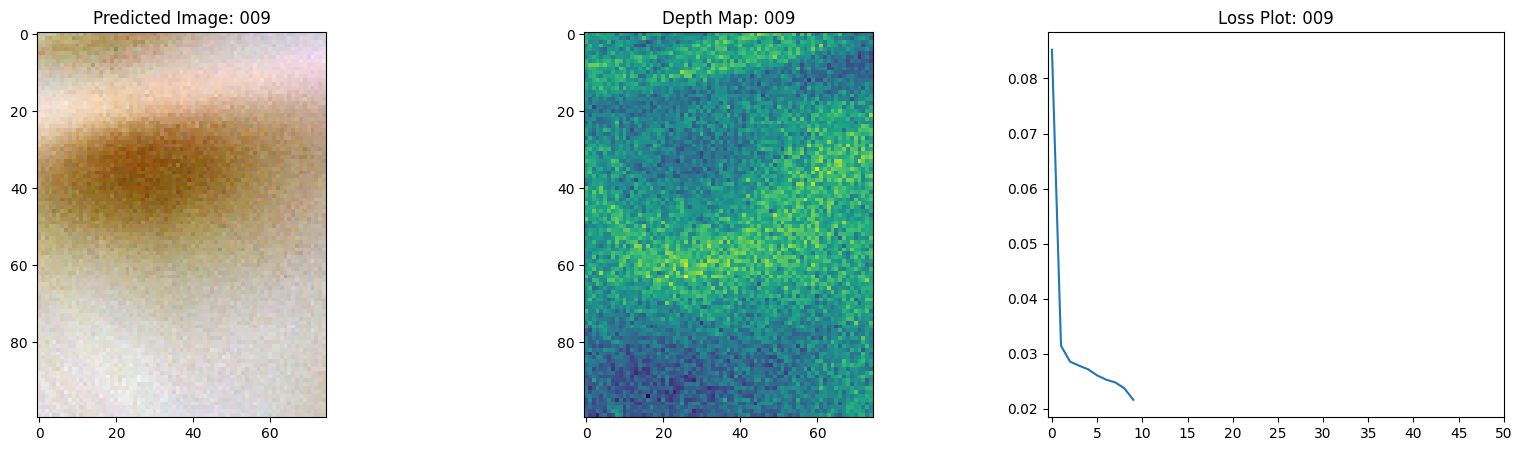

12/12 [==============================] - 22s 2s/step - loss: 0.0216 - psnr: 16.7110 - val_loss: 0.0196 - val_psnr: 17.1231
Epoch 11/50
1/1 [==============================] - 1s 556ms/step


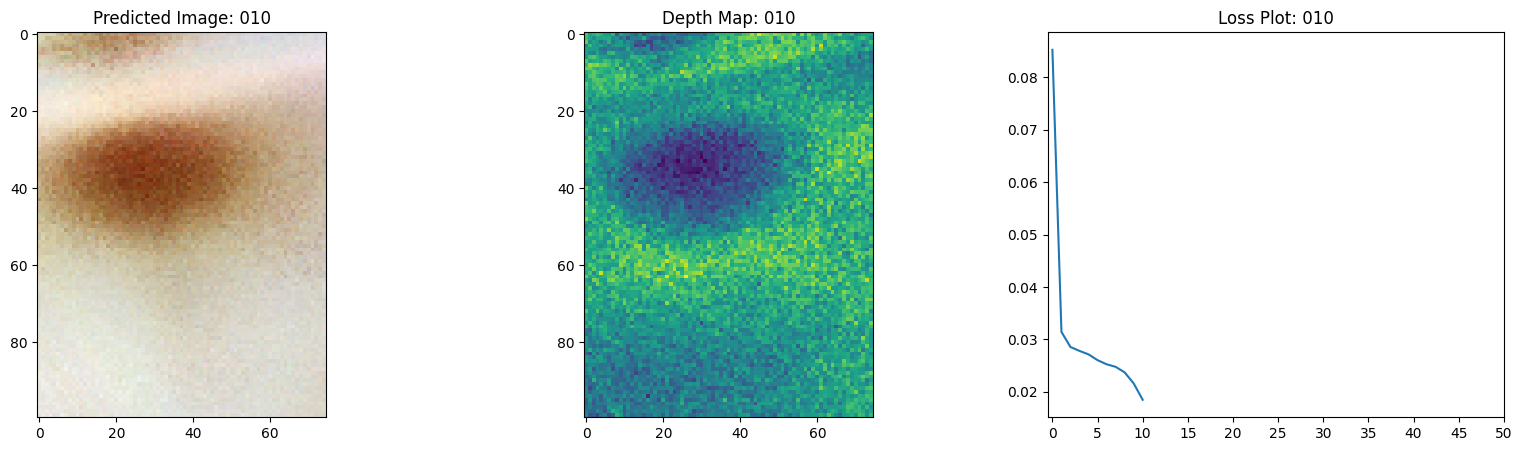

12/12 [==============================] - 23s 2s/step - loss: 0.0185 - psnr: 17.3887 - val_loss: 0.0170 - val_psnr: 17.7444
Epoch 12/50
1/1 [==============================] - 1s 555ms/step


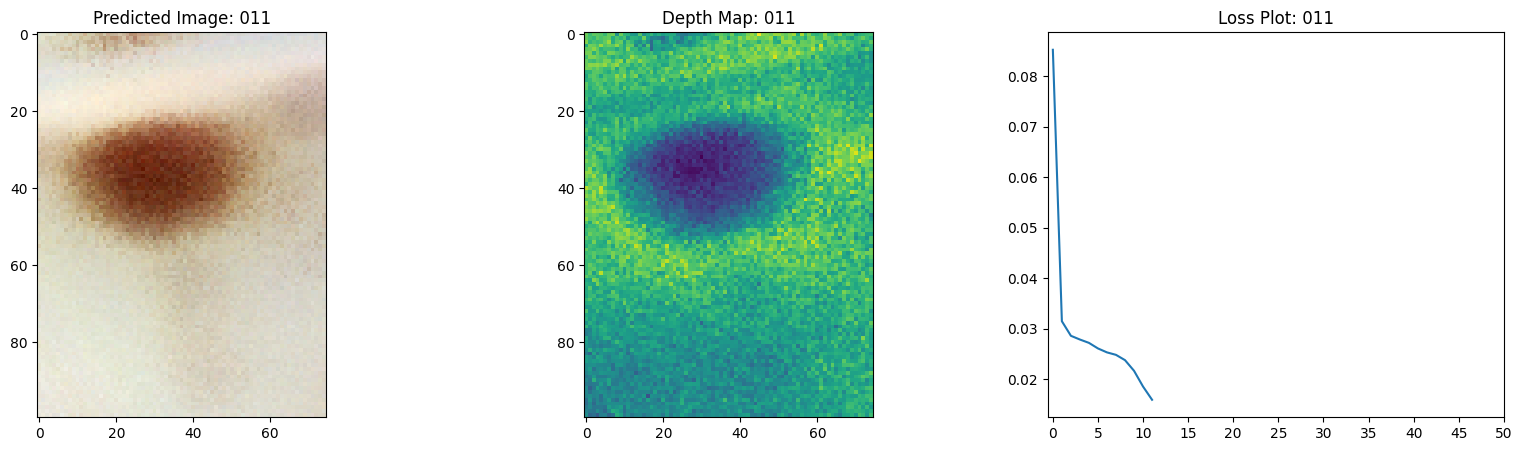

12/12 [==============================] - 23s 2s/step - loss: 0.0159 - psnr: 18.1304 - val_loss: 0.0126 - val_psnr: 19.0377
Epoch 13/50
1/1 [==============================] - 1s 556ms/step


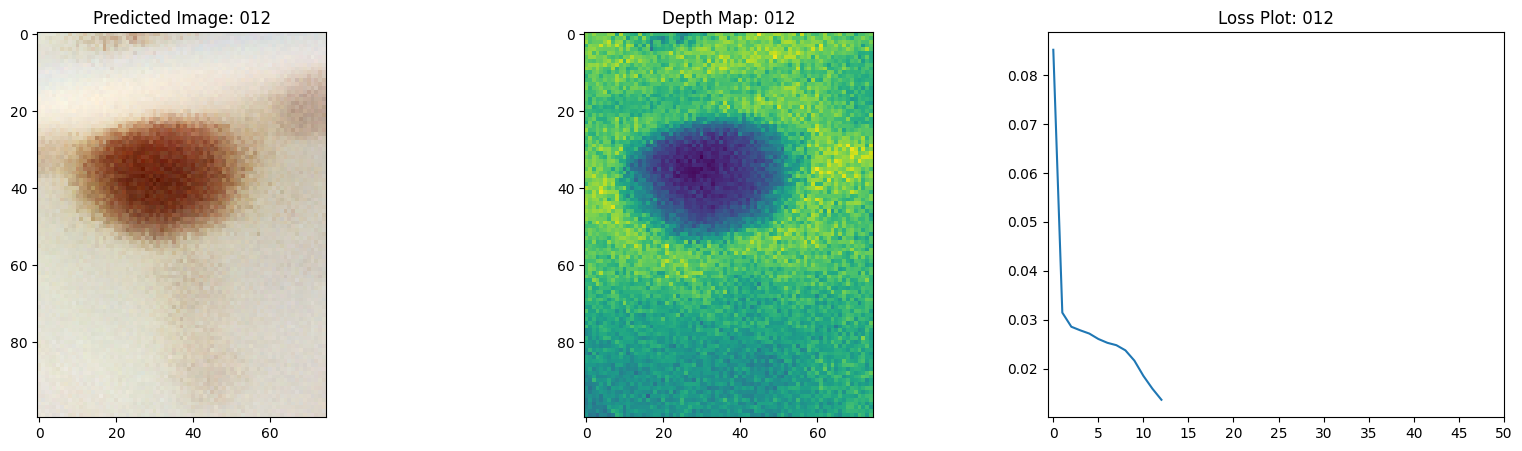

12/12 [==============================] - 22s 2s/step - loss: 0.0136 - psnr: 18.8627 - val_loss: 0.0110 - val_psnr: 19.6104
Epoch 14/50
1/1 [==============================] - 1s 567ms/step


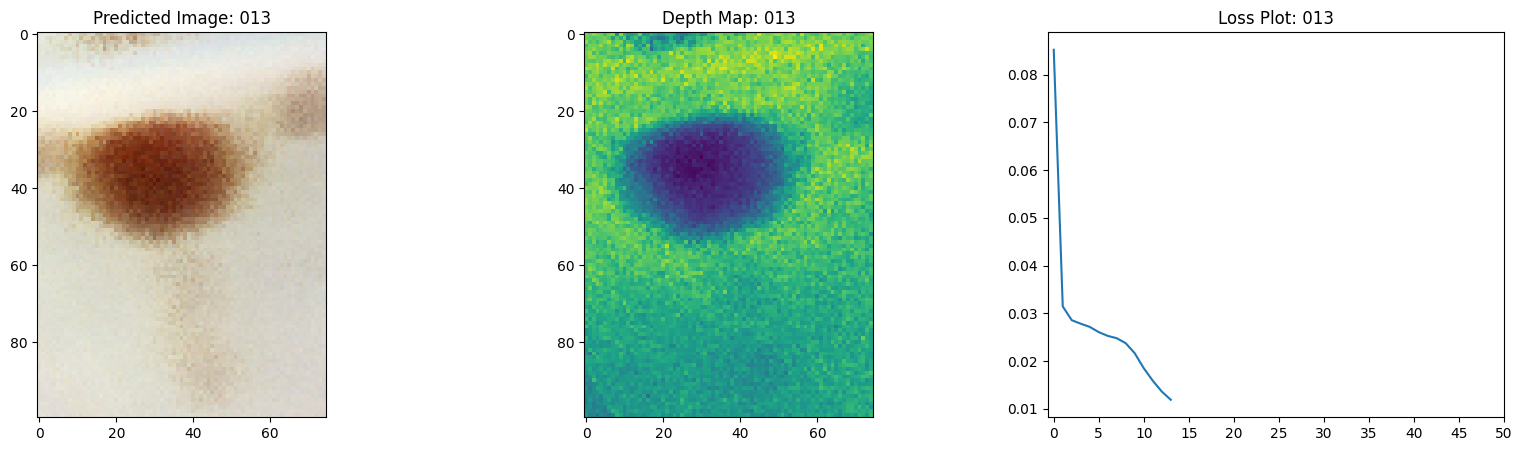

12/12 [==============================] - 23s 2s/step - loss: 0.0119 - psnr: 19.4776 - val_loss: 0.0095 - val_psnr: 20.2855
Epoch 15/50
1/1 [==============================] - 1s 565ms/step


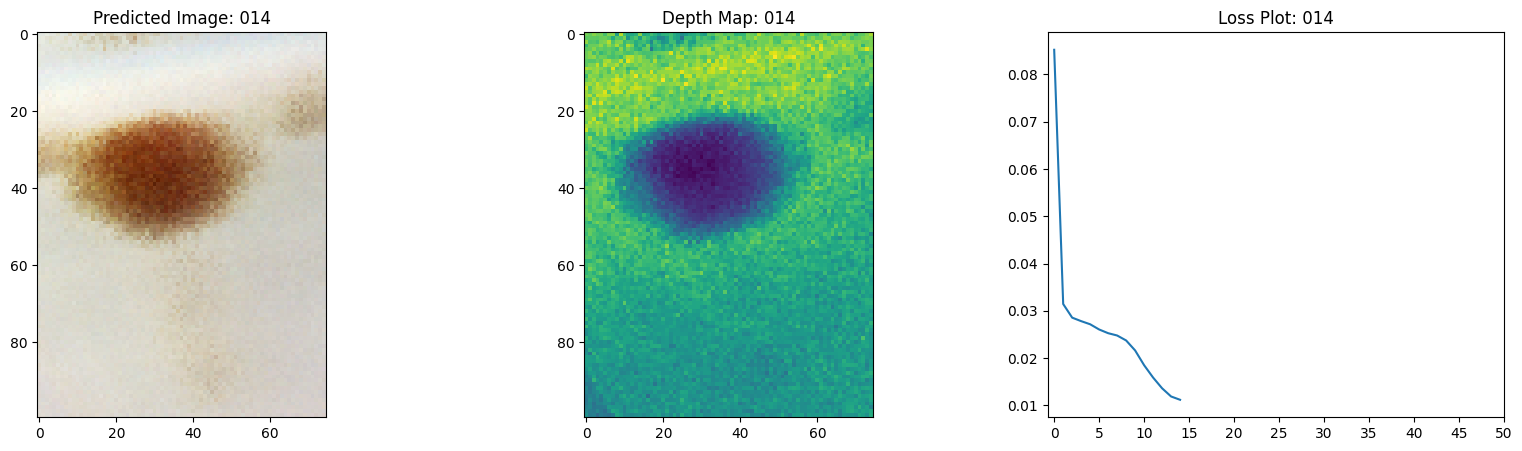

12/12 [==============================] - 24s 2s/step - loss: 0.0112 - psnr: 19.7949 - val_loss: 0.0083 - val_psnr: 20.8545
Epoch 16/50
1/1 [==============================] - 1s 575ms/step


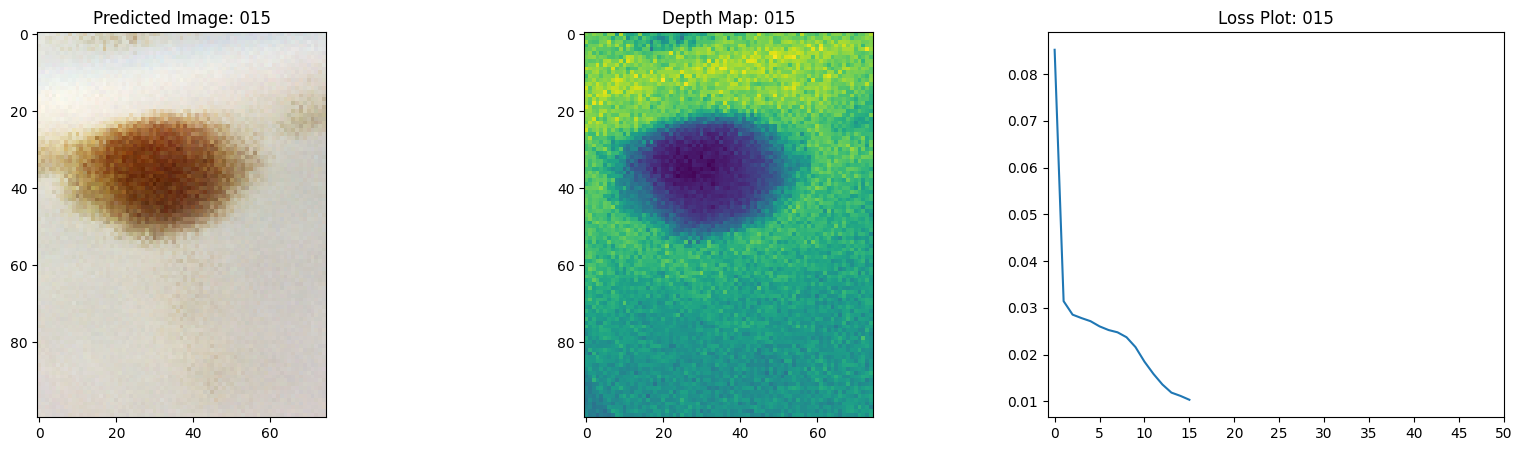

12/12 [==============================] - 28s 2s/step - loss: 0.0104 - psnr: 20.0990 - val_loss: 0.0084 - val_psnr: 20.8063
Epoch 17/50
1/1 [==============================] - 1s 566ms/step


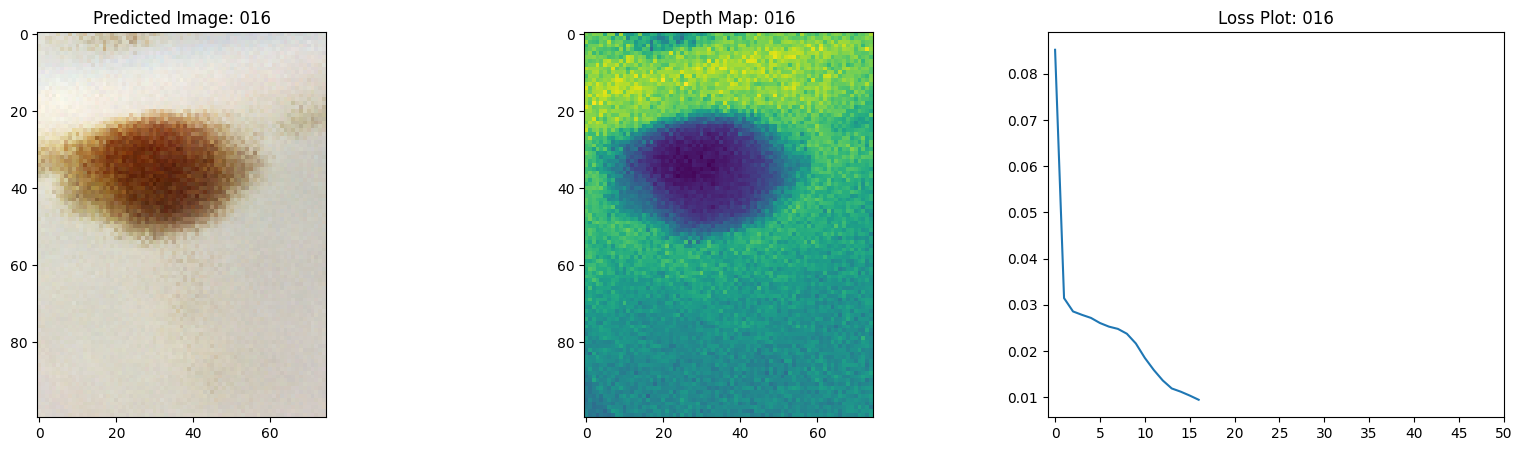

12/12 [==============================] - 24s 2s/step - loss: 0.0094 - psnr: 20.4817 - val_loss: 0.0076 - val_psnr: 21.2775
Epoch 18/50
1/1 [==============================] - 1s 568ms/step


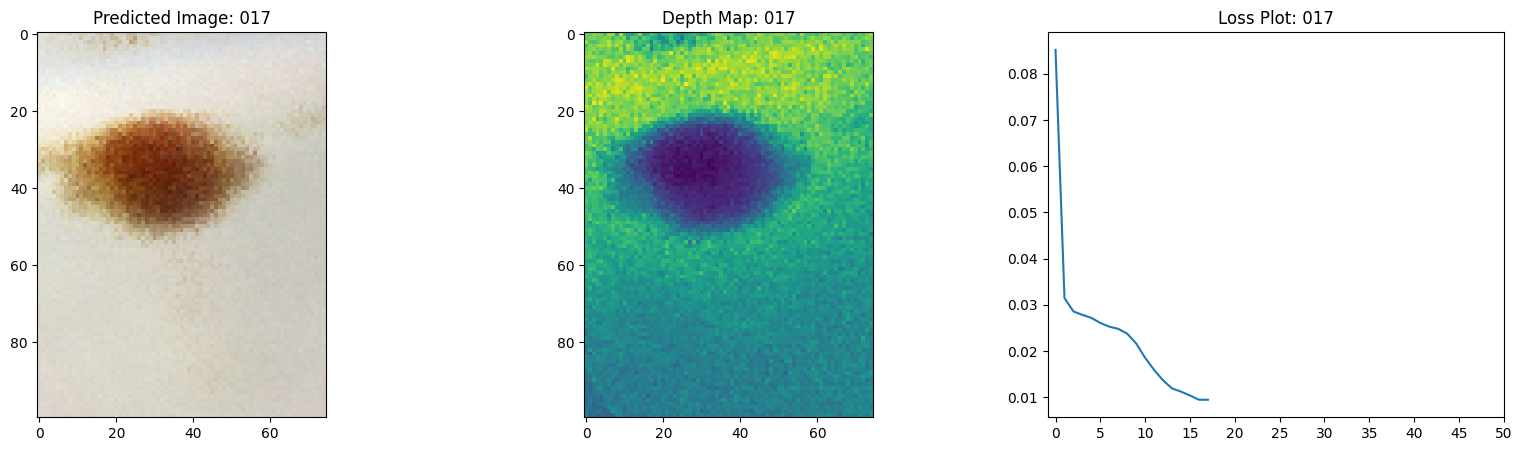

12/12 [==============================] - 27s 2s/step - loss: 0.0094 - psnr: 20.5342 - val_loss: 0.0073 - val_psnr: 21.4670
Epoch 19/50
1/1 [==============================] - 1s 557ms/step


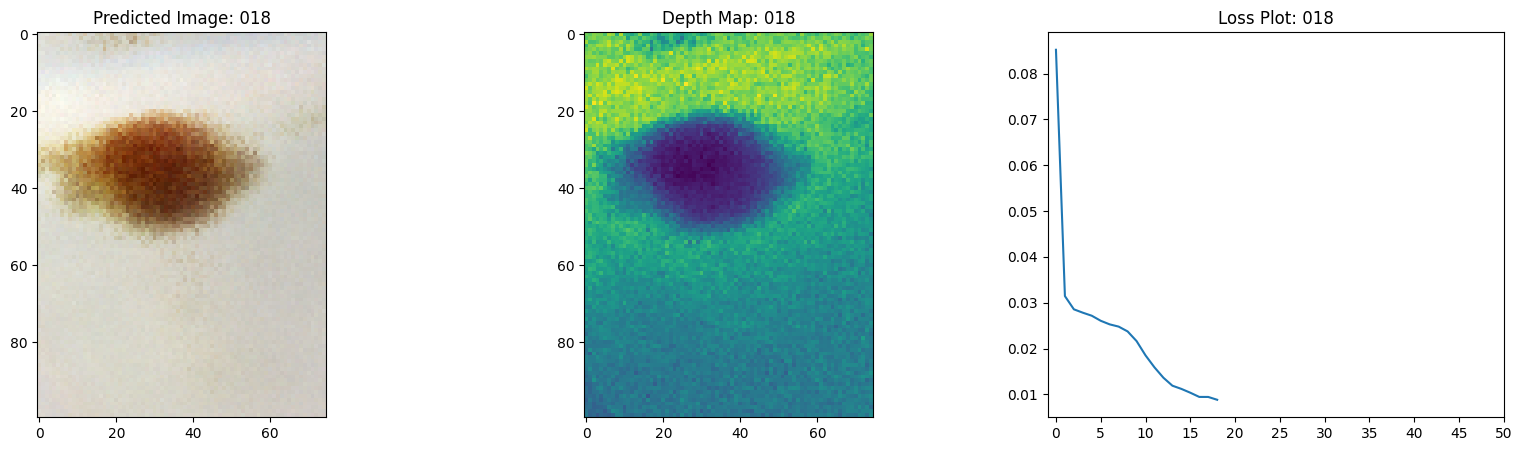

12/12 [==============================] - 23s 2s/step - loss: 0.0088 - psnr: 20.8095 - val_loss: 0.0070 - val_psnr: 21.6275
Epoch 20/50
1/1 [==============================] - 1s 560ms/step


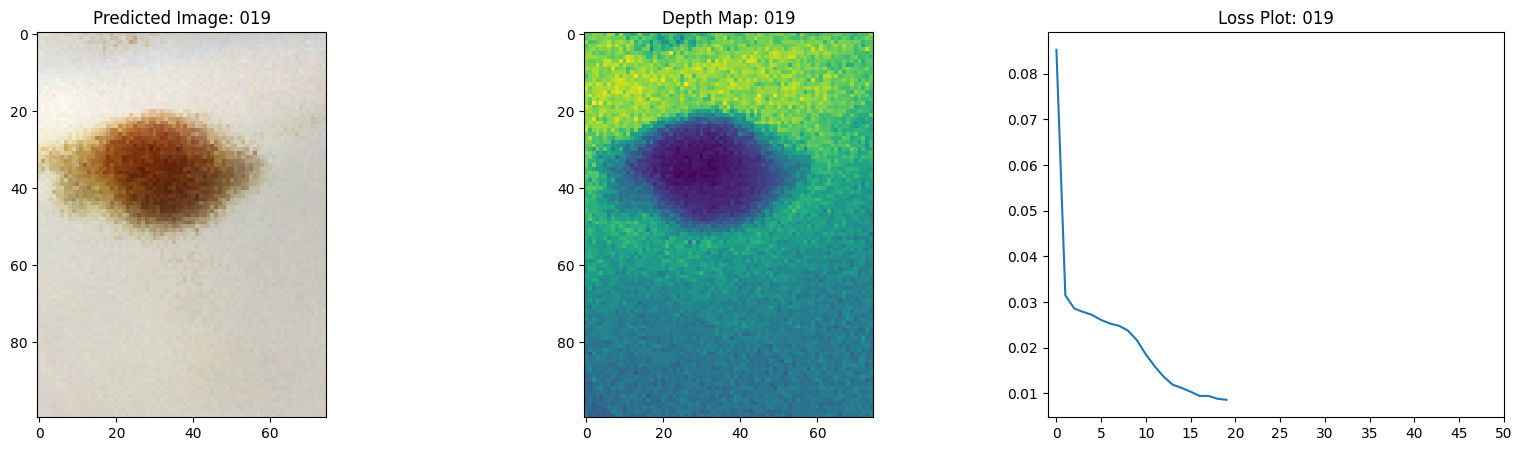

12/12 [==============================] - 22s 2s/step - loss: 0.0086 - psnr: 20.9273 - val_loss: 0.0068 - val_psnr: 21.7082
Epoch 21/50
1/1 [==============================] - 1s 574ms/step


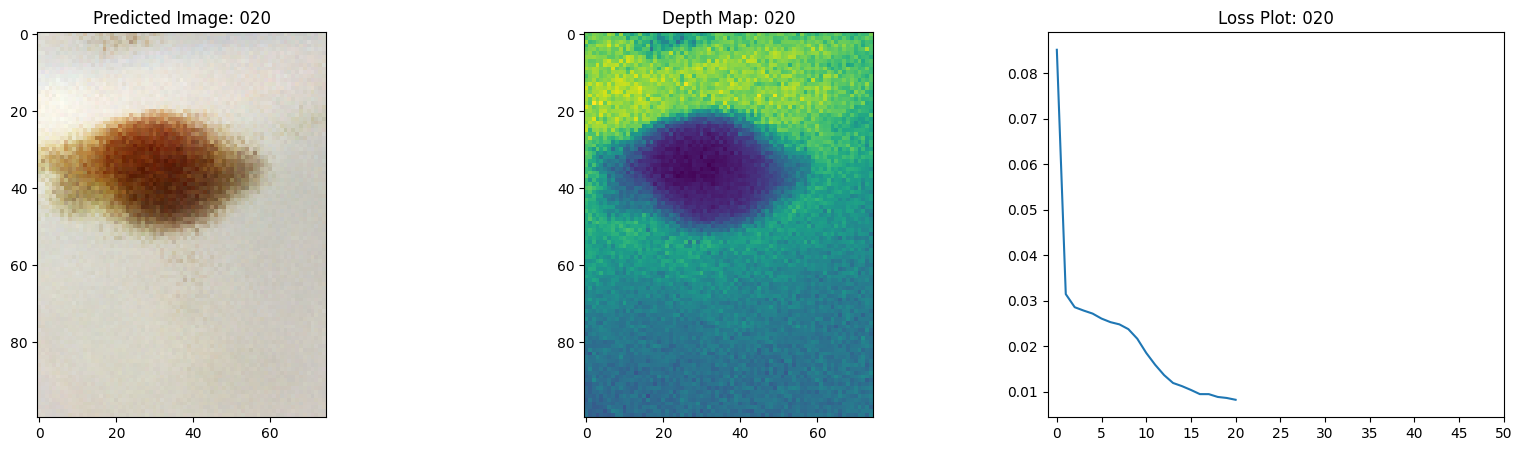

12/12 [==============================] - 22s 2s/step - loss: 0.0082 - psnr: 21.1063 - val_loss: 0.0067 - val_psnr: 21.8575
Epoch 22/50
1/1 [==============================] - 1s 556ms/step


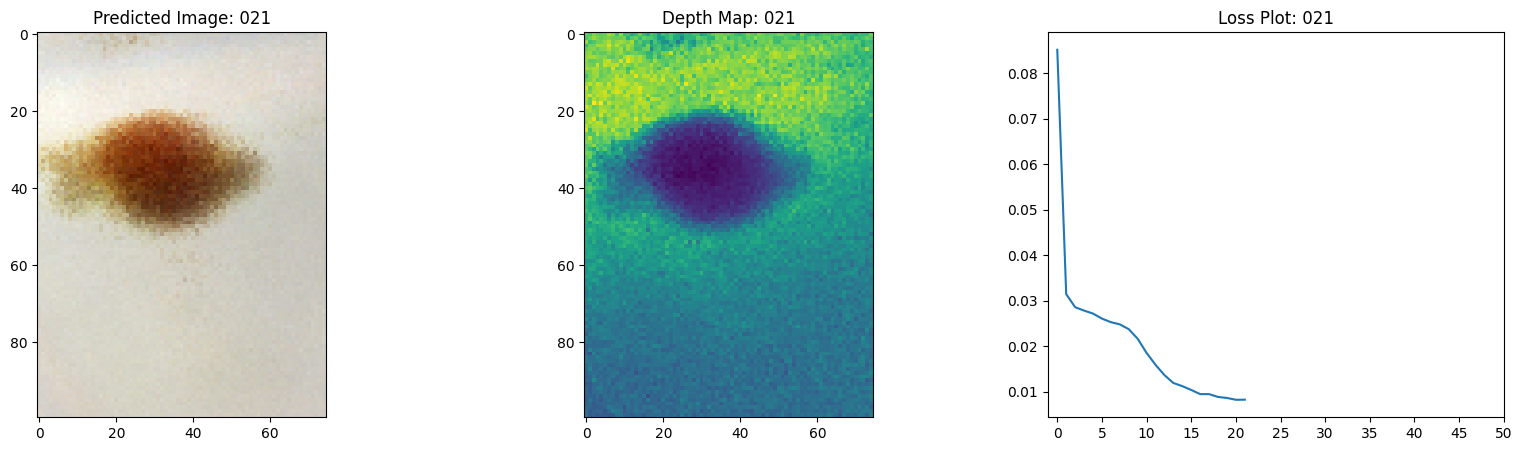

12/12 [==============================] - 22s 2s/step - loss: 0.0082 - psnr: 21.1384 - val_loss: 0.0065 - val_psnr: 21.9570
Epoch 23/50
1/1 [==============================] - 1s 552ms/step


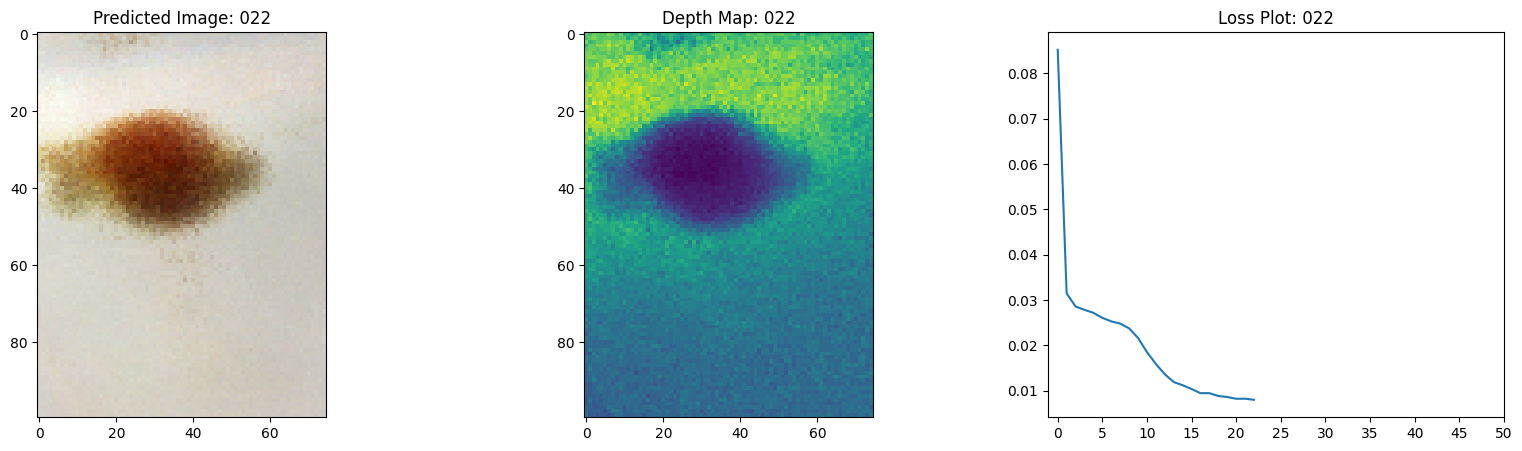

12/12 [==============================] - 22s 2s/step - loss: 0.0080 - psnr: 21.2164 - val_loss: 0.0065 - val_psnr: 21.9608
Epoch 24/50
1/1 [==============================] - 1s 550ms/step


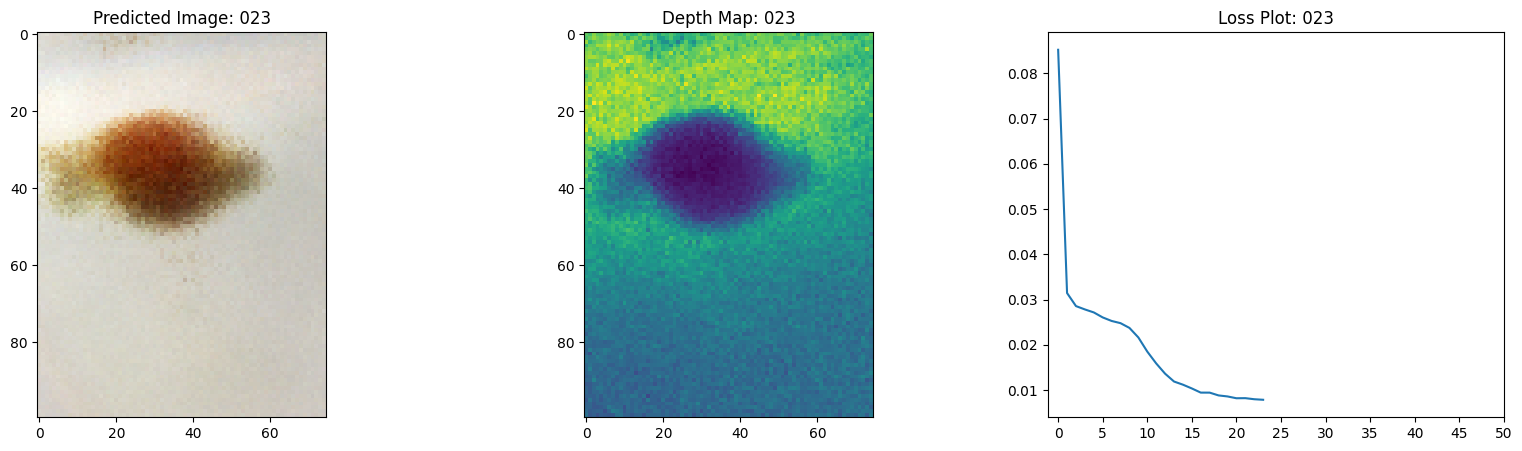

12/12 [==============================] - 21s 2s/step - loss: 0.0078 - psnr: 21.3088 - val_loss: 0.0063 - val_psnr: 22.0178
Epoch 25/50
1/1 [==============================] - 1s 574ms/step


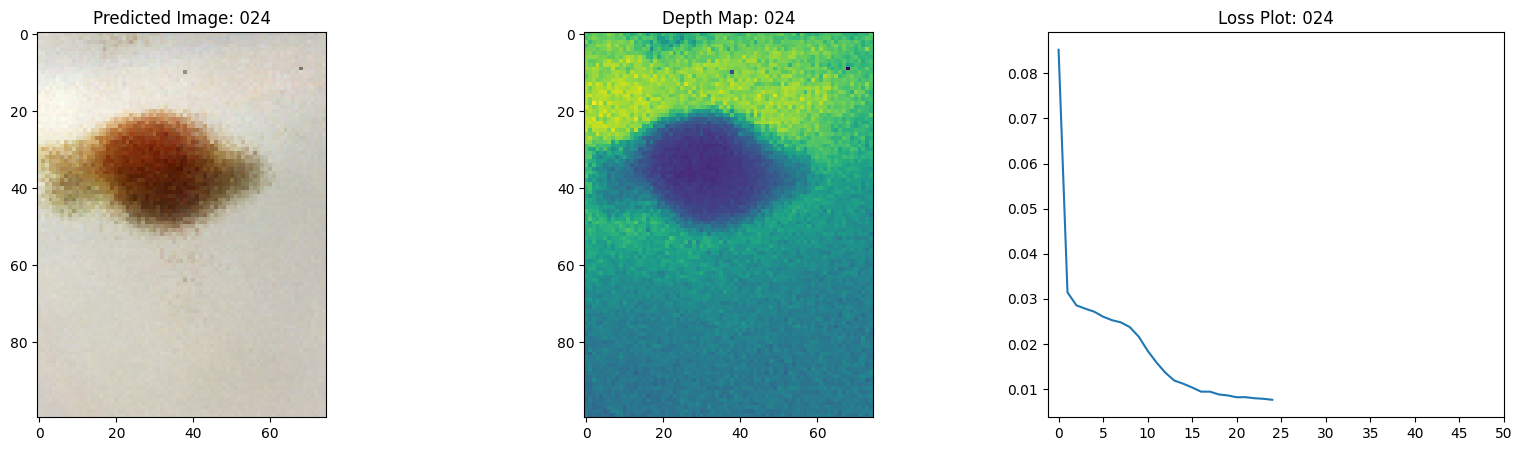

12/12 [==============================] - 22s 2s/step - loss: 0.0076 - psnr: 21.4297 - val_loss: 0.0065 - val_psnr: 21.9456
Epoch 26/50
1/1 [==============================] - 1s 554ms/step


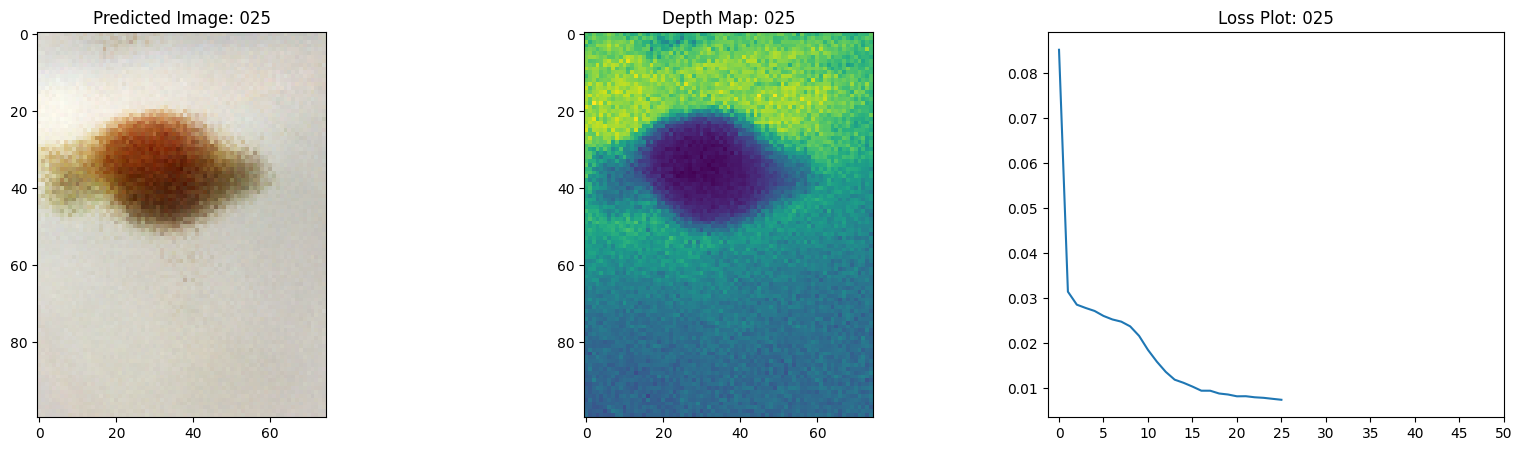

12/12 [==============================] - 21s 2s/step - loss: 0.0074 - psnr: 21.5552 - val_loss: 0.0063 - val_psnr: 22.0858
Epoch 27/50
1/1 [==============================] - 1s 558ms/step


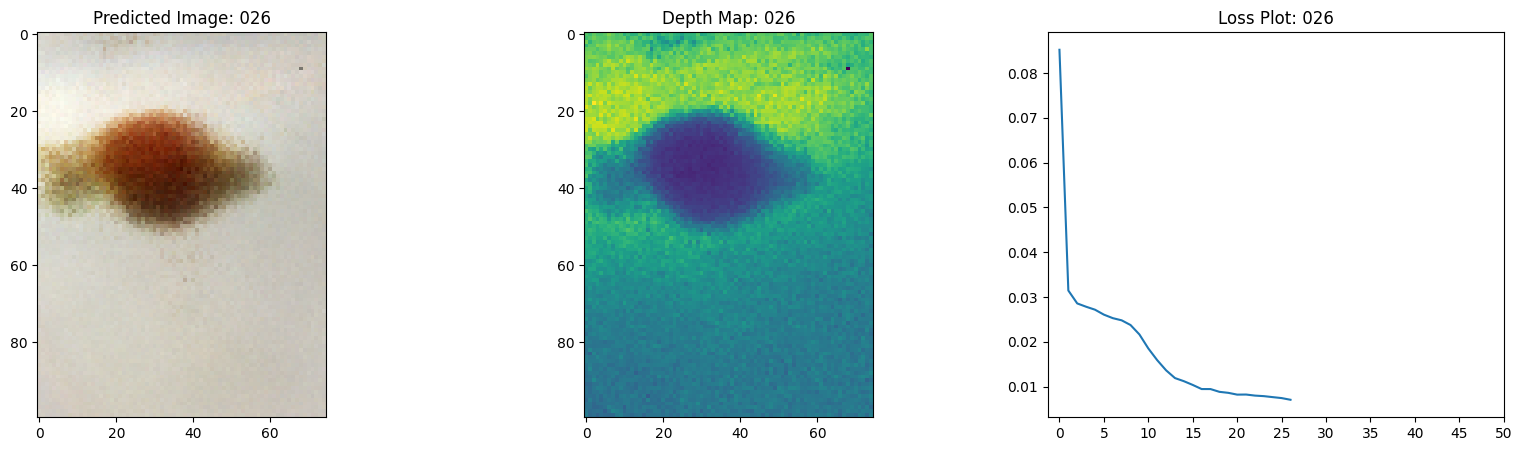

12/12 [==============================] - 24s 2s/step - loss: 0.0070 - psnr: 21.7699 - val_loss: 0.0061 - val_psnr: 22.1890
Epoch 28/50
1/1 [==============================] - 1s 549ms/step


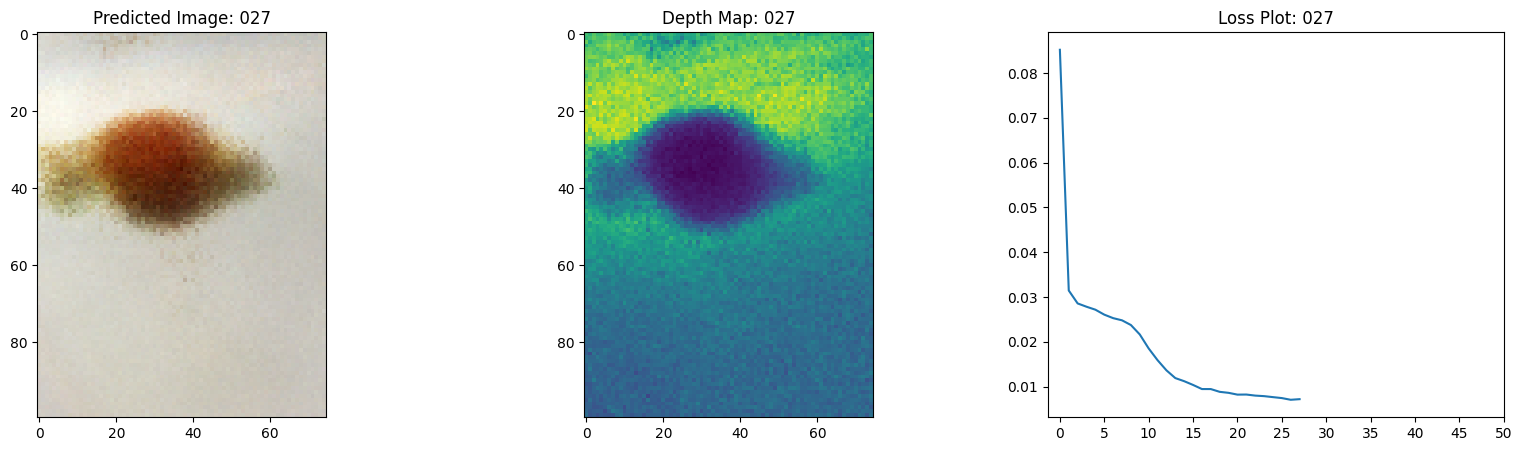

12/12 [==============================] - 22s 2s/step - loss: 0.0072 - psnr: 21.7072 - val_loss: 0.0060 - val_psnr: 22.2943
Epoch 29/50
1/1 [==============================] - 1s 560ms/step


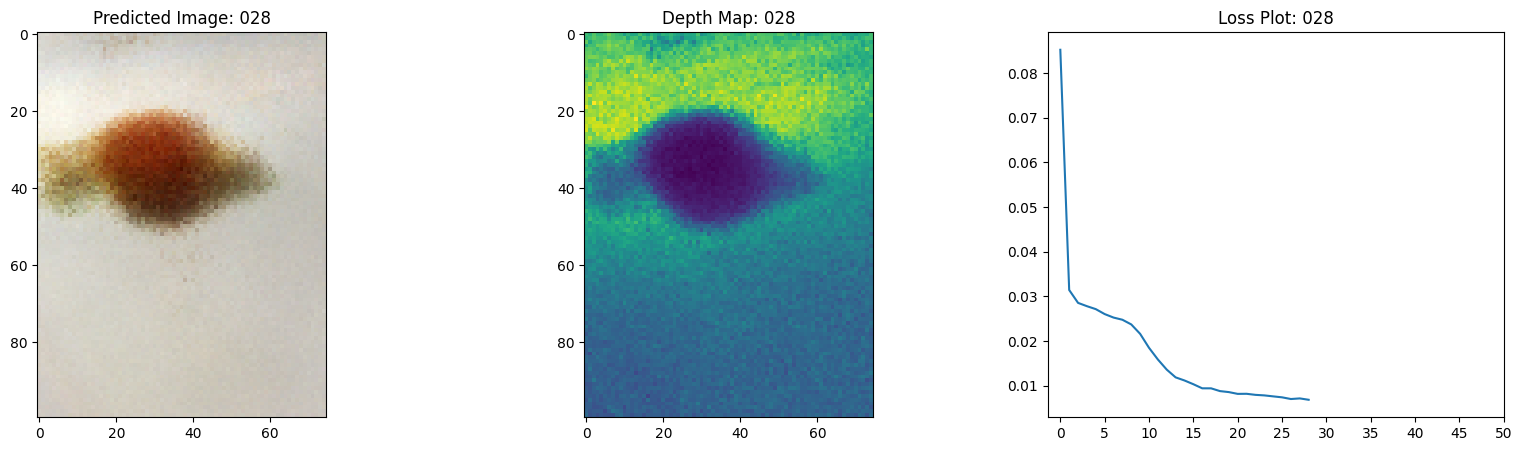

12/12 [==============================] - 22s 2s/step - loss: 0.0069 - psnr: 21.9097 - val_loss: 0.0056 - val_psnr: 22.5707
Epoch 30/50
1/1 [==============================] - 1s 554ms/step


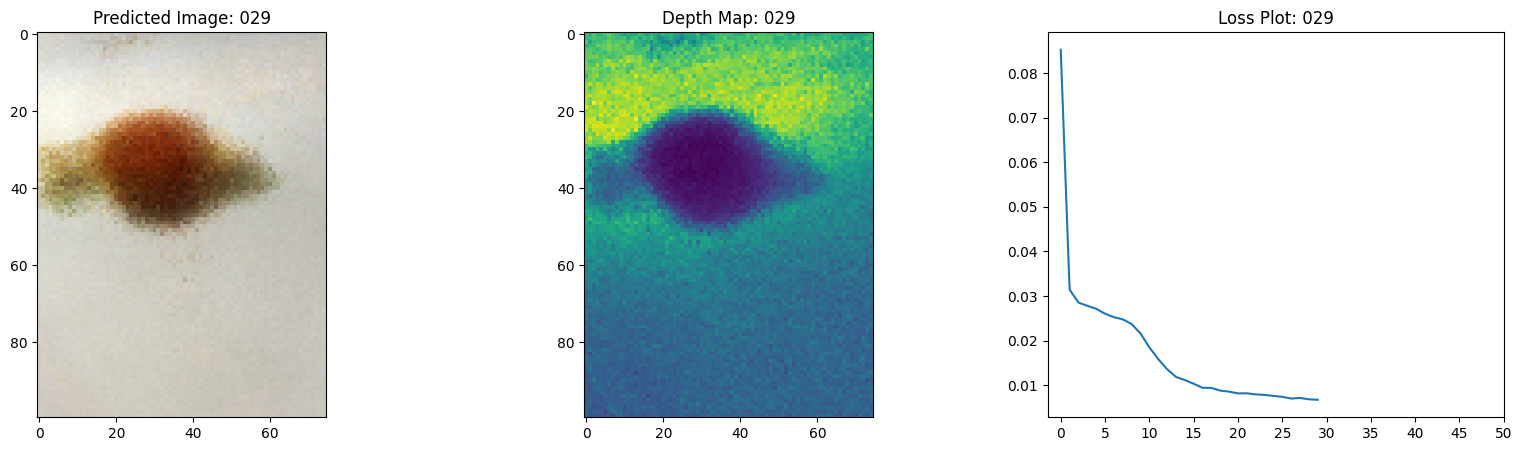

12/12 [==============================] - 23s 2s/step - loss: 0.0068 - psnr: 21.9662 - val_loss: 0.0056 - val_psnr: 22.5651
Epoch 31/50
1/1 [==============================] - 1s 574ms/step


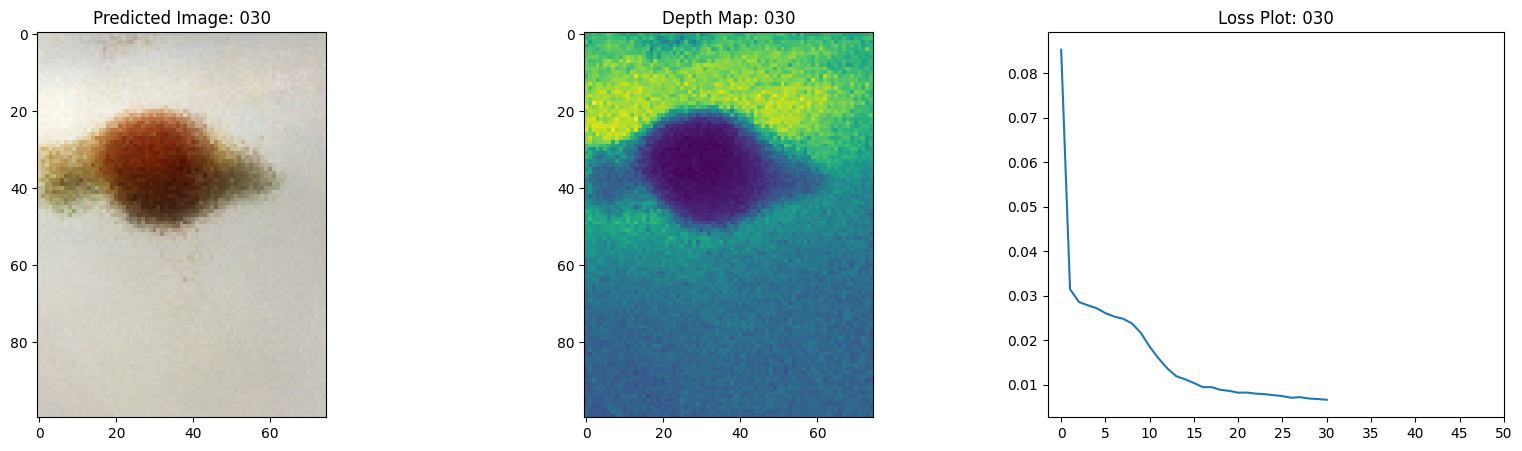

12/12 [==============================] - 23s 2s/step - loss: 0.0066 - psnr: 22.0901 - val_loss: 0.0055 - val_psnr: 22.6791
Epoch 32/50
1/1 [==============================] - 1s 594ms/step


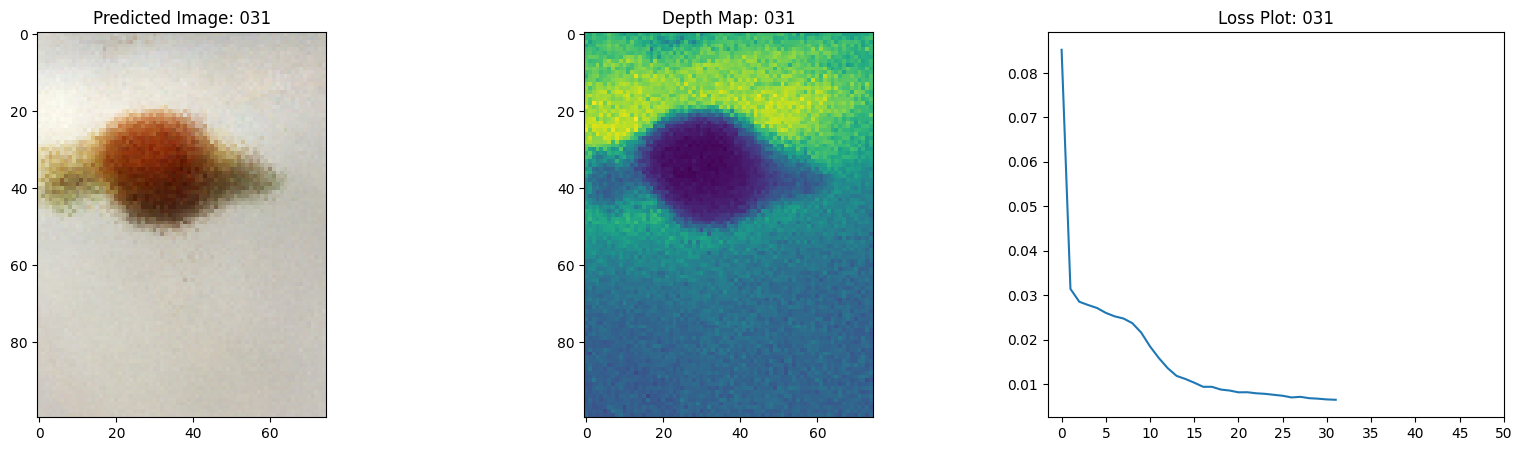

12/12 [==============================] - 23s 2s/step - loss: 0.0065 - psnr: 22.1476 - val_loss: 0.0056 - val_psnr: 22.5831
Epoch 33/50
1/1 [==============================] - 1s 574ms/step


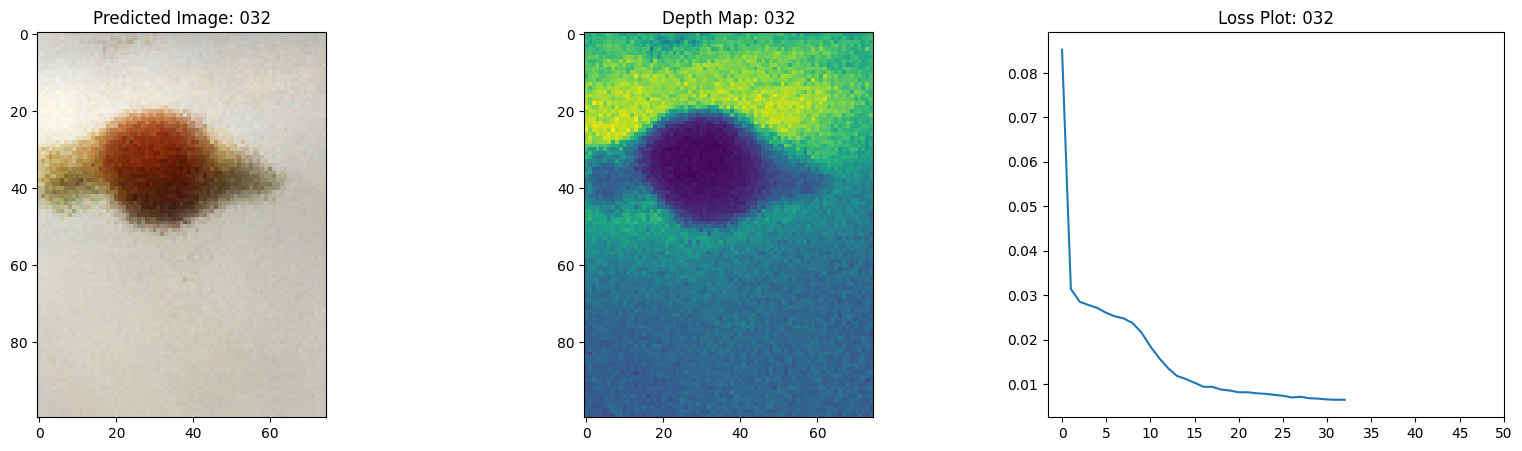

12/12 [==============================] - 22s 2s/step - loss: 0.0065 - psnr: 22.1429 - val_loss: 0.0053 - val_psnr: 22.7821
Epoch 34/50
1/1 [==============================] - 1s 587ms/step


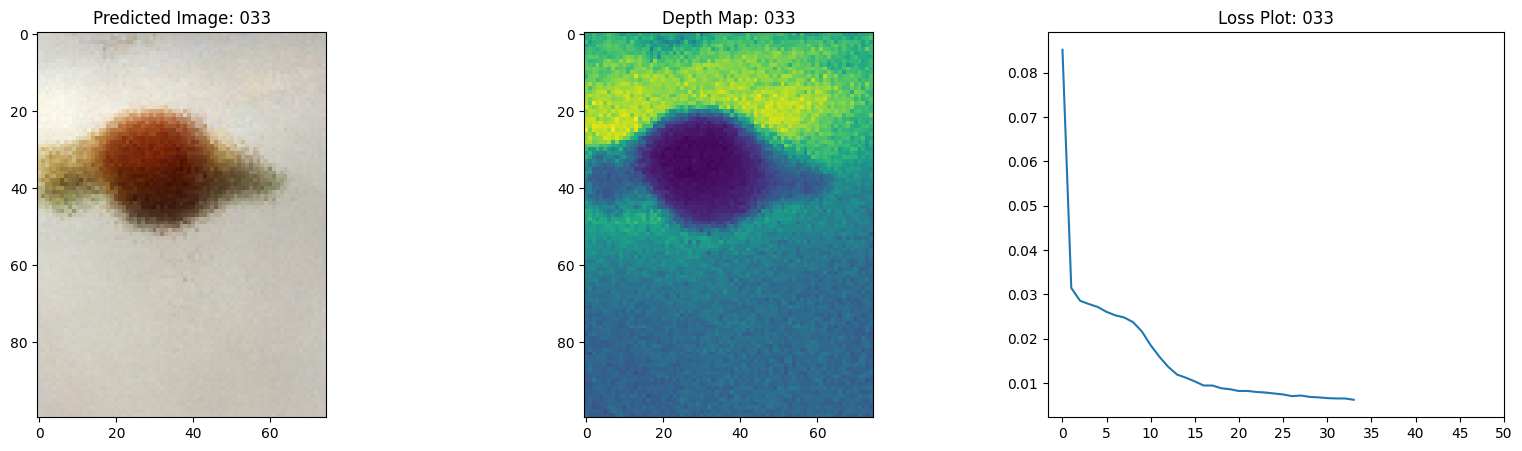

12/12 [==============================] - 21s 2s/step - loss: 0.0062 - psnr: 22.3406 - val_loss: 0.0053 - val_psnr: 22.8747
Epoch 35/50
1/1 [==============================] - 1s 562ms/step


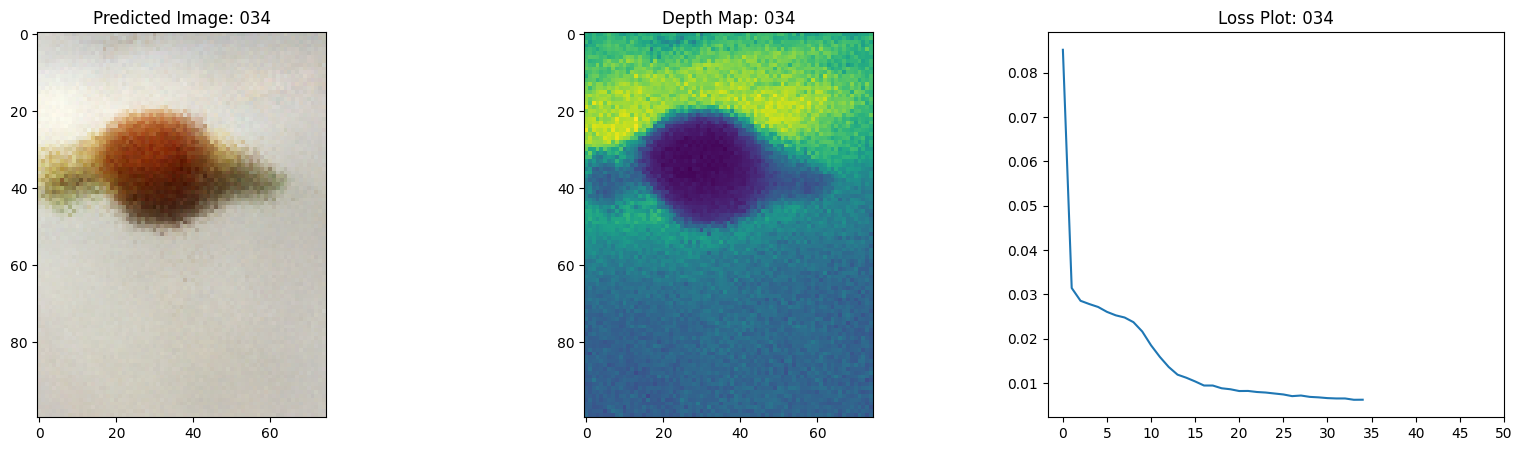

12/12 [==============================] - 23s 2s/step - loss: 0.0062 - psnr: 22.3457 - val_loss: 0.0054 - val_psnr: 22.6925
Epoch 36/50
1/1 [==============================] - 1s 555ms/step


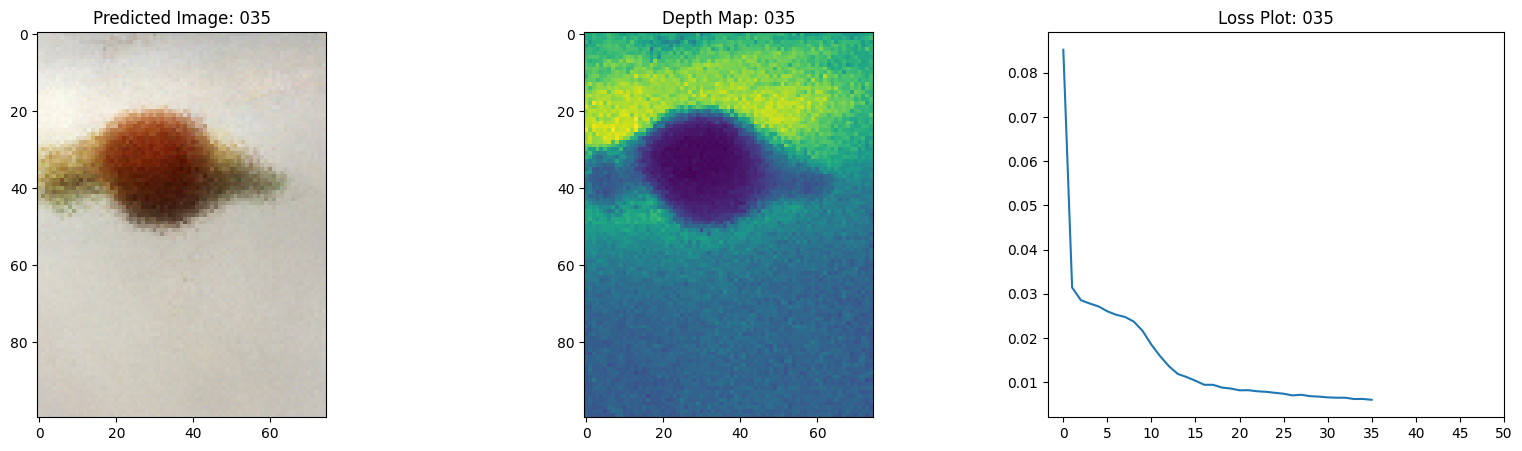

12/12 [==============================] - 22s 2s/step - loss: 0.0060 - psnr: 22.4259 - val_loss: 0.0050 - val_psnr: 23.0618
Epoch 37/50
1/1 [==============================] - 1s 661ms/step


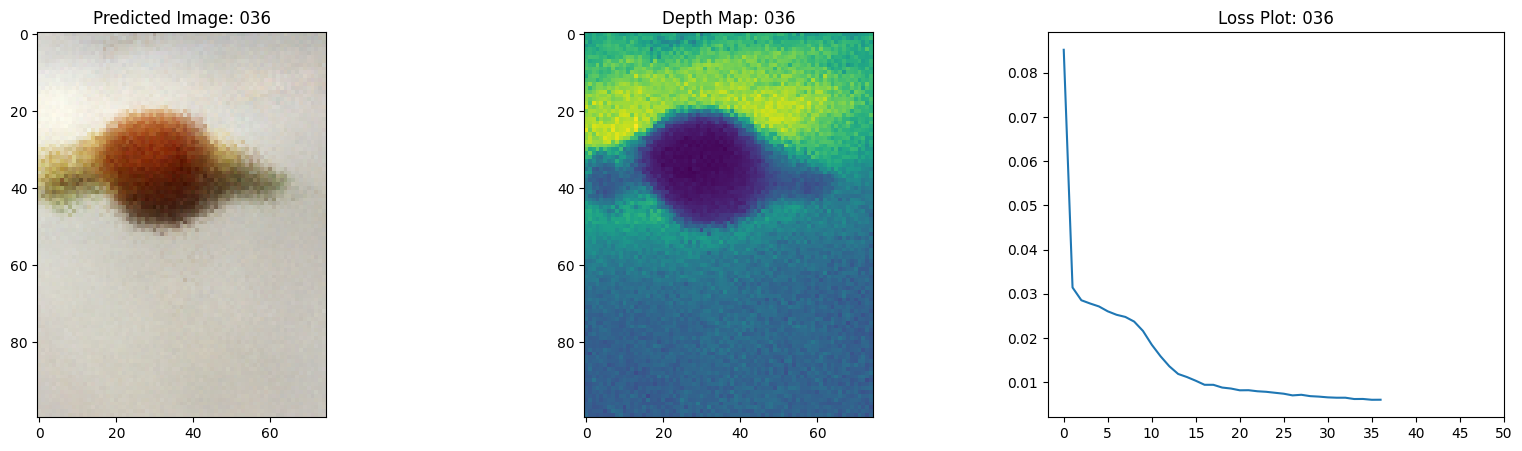

12/12 [==============================] - 23s 2s/step - loss: 0.0061 - psnr: 22.4904 - val_loss: 0.0052 - val_psnr: 22.8716
Epoch 38/50
1/1 [==============================] - 1s 571ms/step


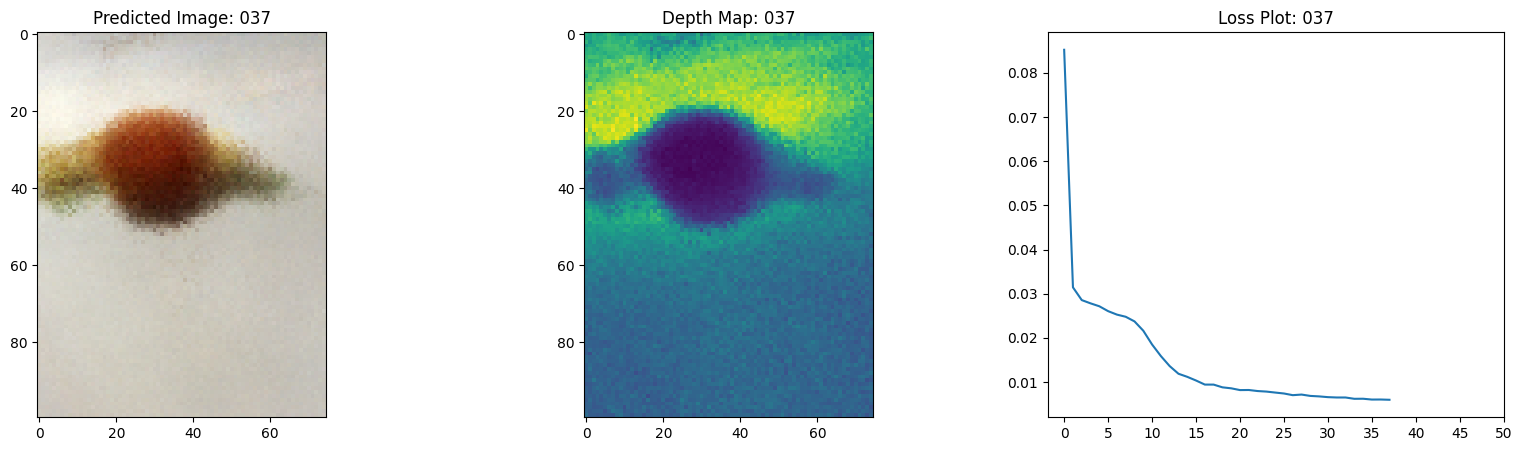

12/12 [==============================] - 29s 2s/step - loss: 0.0060 - psnr: 22.5228 - val_loss: 0.0052 - val_psnr: 22.9180
Epoch 39/50
1/1 [==============================] - 1s 557ms/step


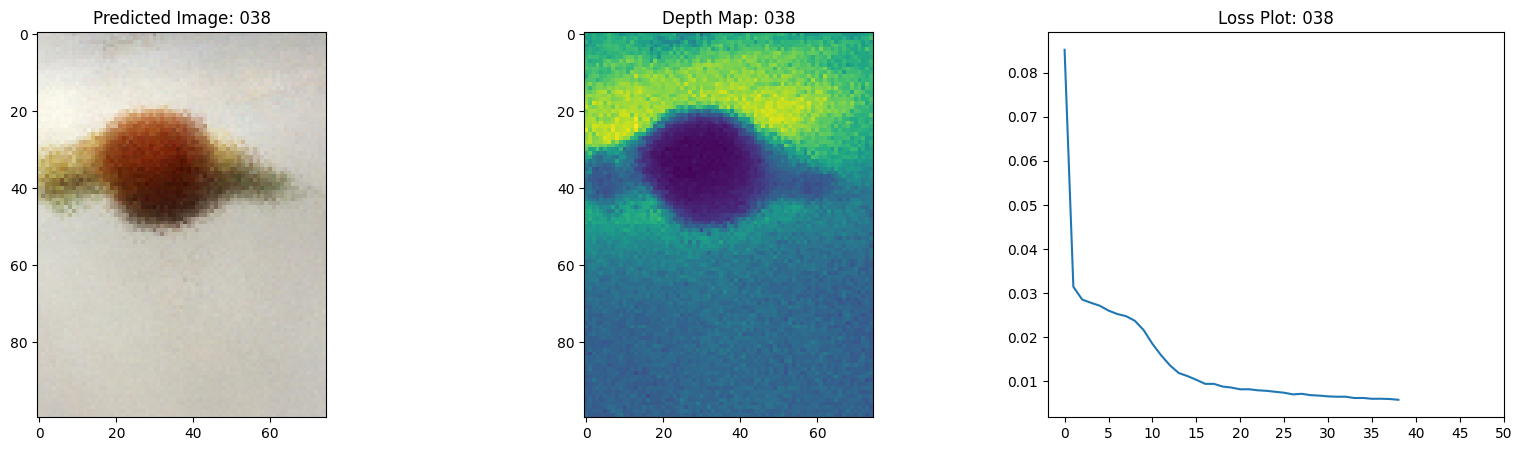

12/12 [==============================] - 22s 2s/step - loss: 0.0058 - psnr: 22.6404 - val_loss: 0.0049 - val_psnr: 23.1746
Epoch 40/50
1/1 [==============================] - 1s 550ms/step


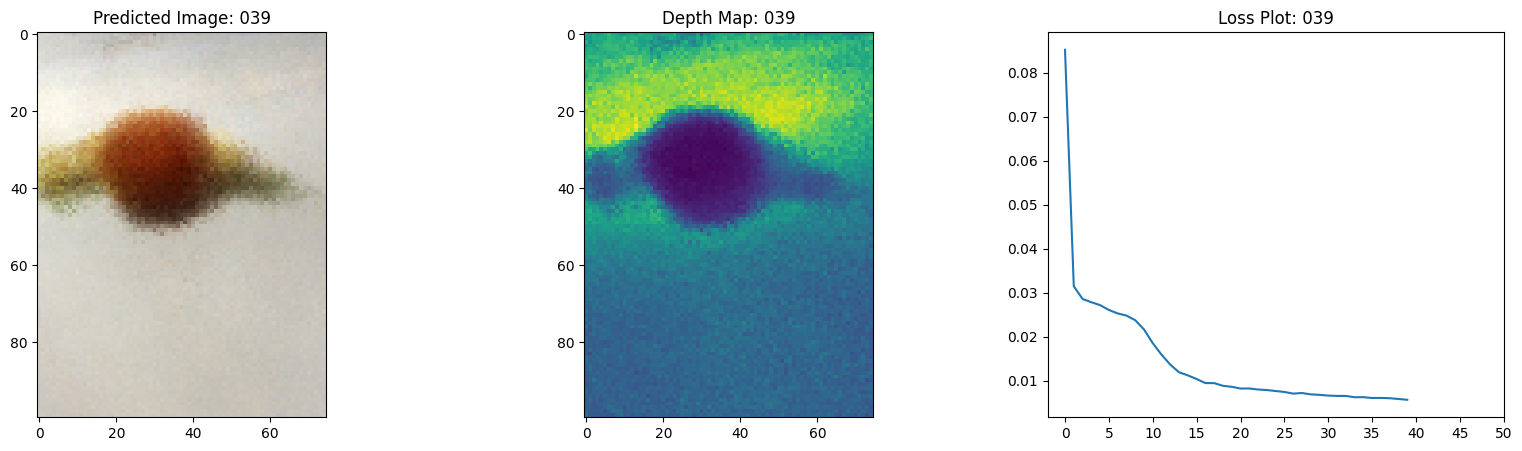

12/12 [==============================] - 21s 2s/step - loss: 0.0056 - psnr: 22.8073 - val_loss: 0.0048 - val_psnr: 23.2586
Epoch 41/50
1/1 [==============================] - 1s 564ms/step


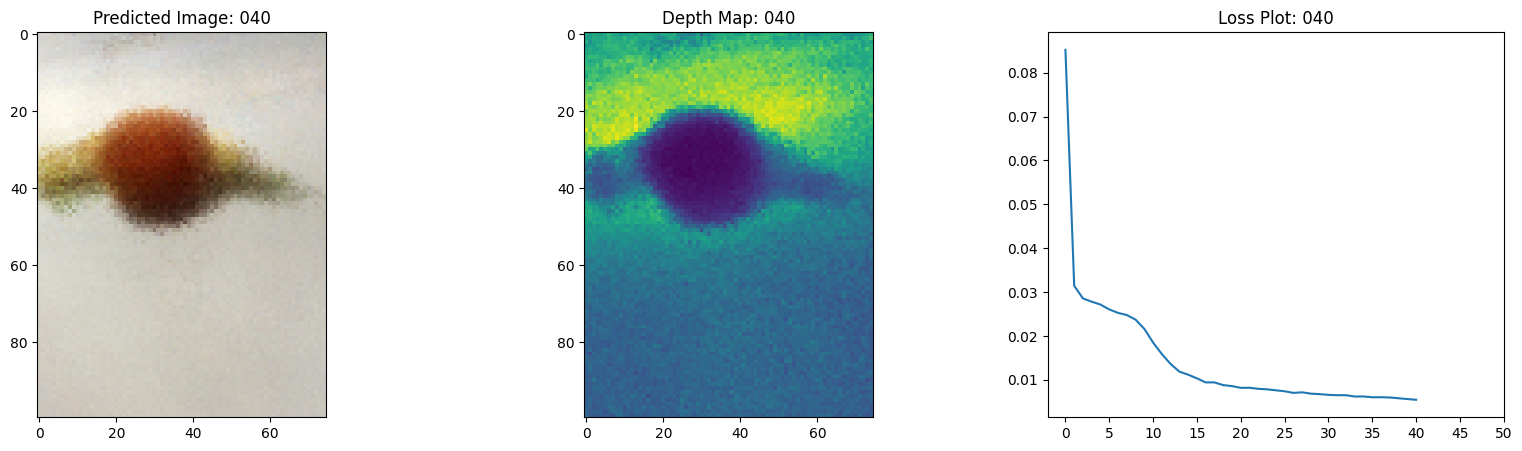

12/12 [==============================] - 22s 2s/step - loss: 0.0055 - psnr: 22.8847 - val_loss: 0.0049 - val_psnr: 23.1337
Epoch 42/50
1/1 [==============================] - 1s 562ms/step


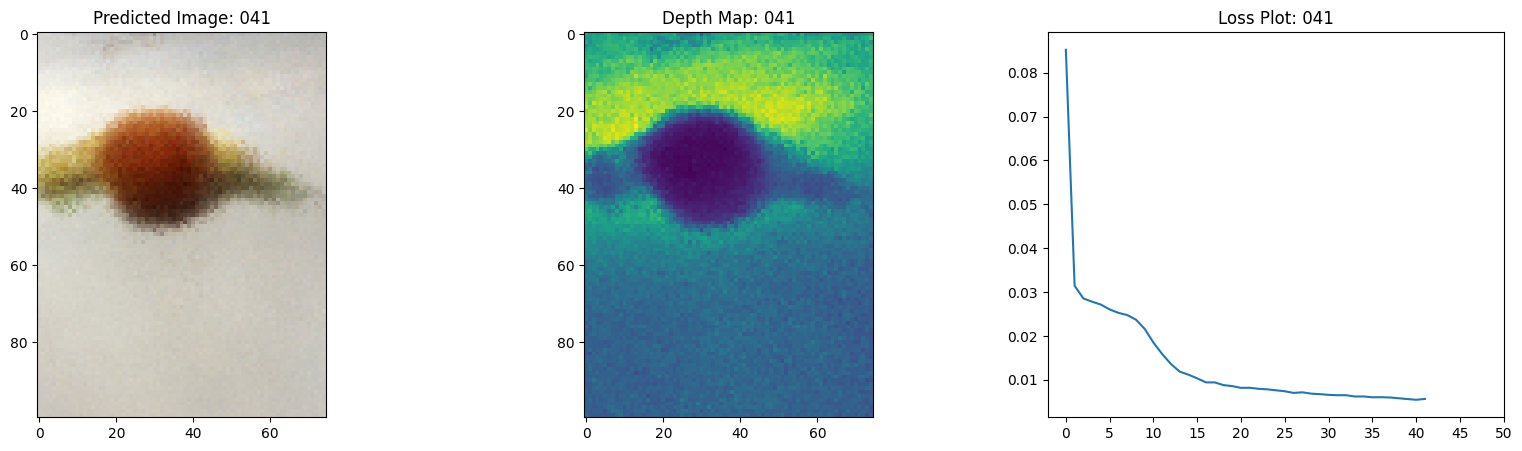

12/12 [==============================] - 21s 2s/step - loss: 0.0057 - psnr: 22.7832 - val_loss: 0.0049 - val_psnr: 23.1770
Epoch 43/50
1/1 [==============================] - 1s 553ms/step


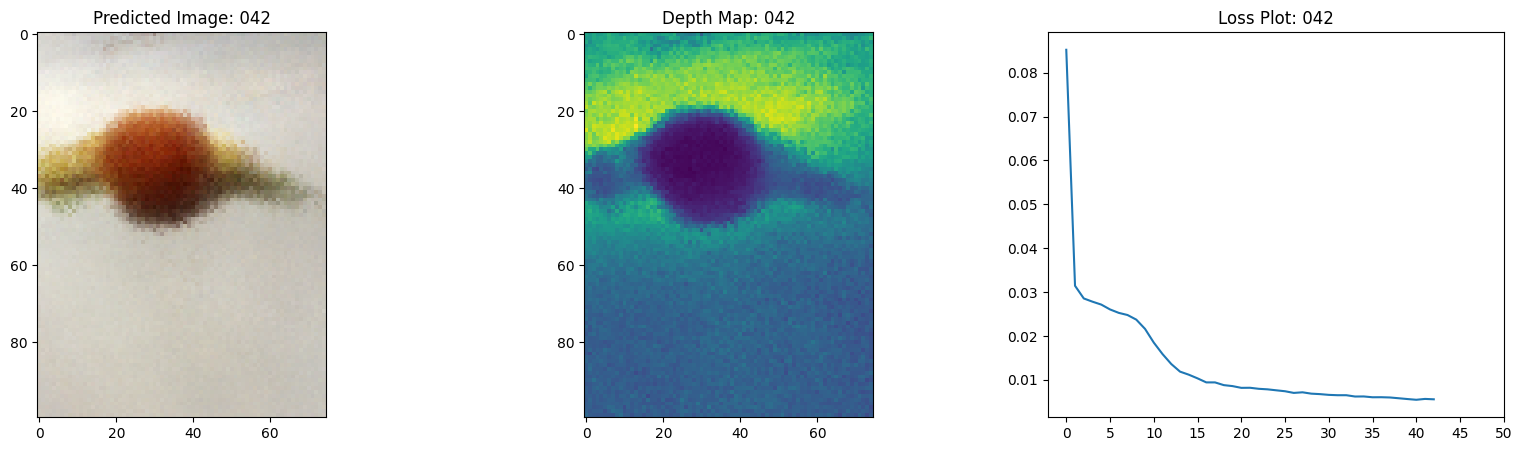

12/12 [==============================] - 22s 2s/step - loss: 0.0056 - psnr: 22.8497 - val_loss: 0.0046 - val_psnr: 23.3982
Epoch 44/50
1/1 [==============================] - 1s 550ms/step


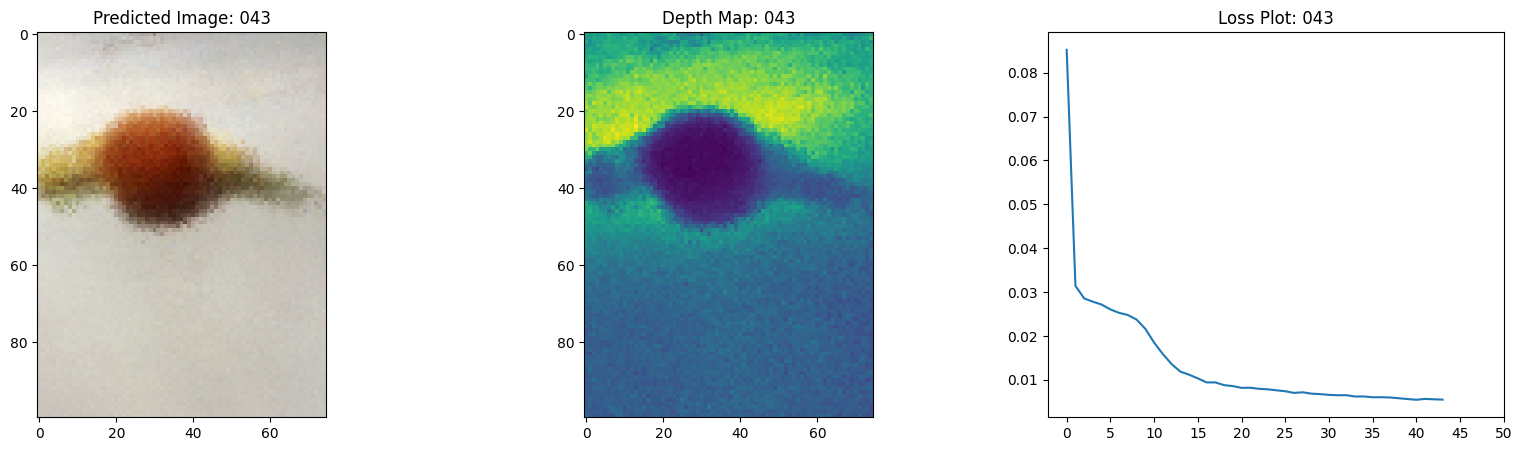

12/12 [==============================] - 23s 2s/step - loss: 0.0055 - psnr: 22.9066 - val_loss: 0.0048 - val_psnr: 23.2360
Epoch 45/50
1/1 [==============================] - 1s 646ms/step


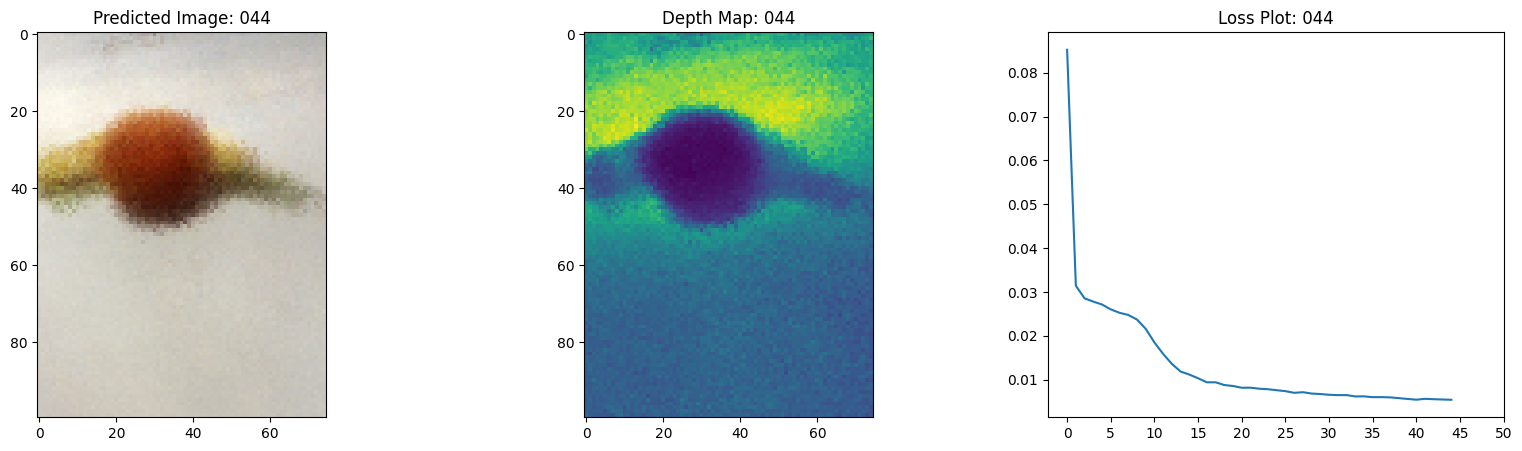

12/12 [==============================] - 22s 2s/step - loss: 0.0054 - psnr: 22.9650 - val_loss: 0.0045 - val_psnr: 23.5173
Epoch 46/50
1/1 [==============================] - 1s 559ms/step


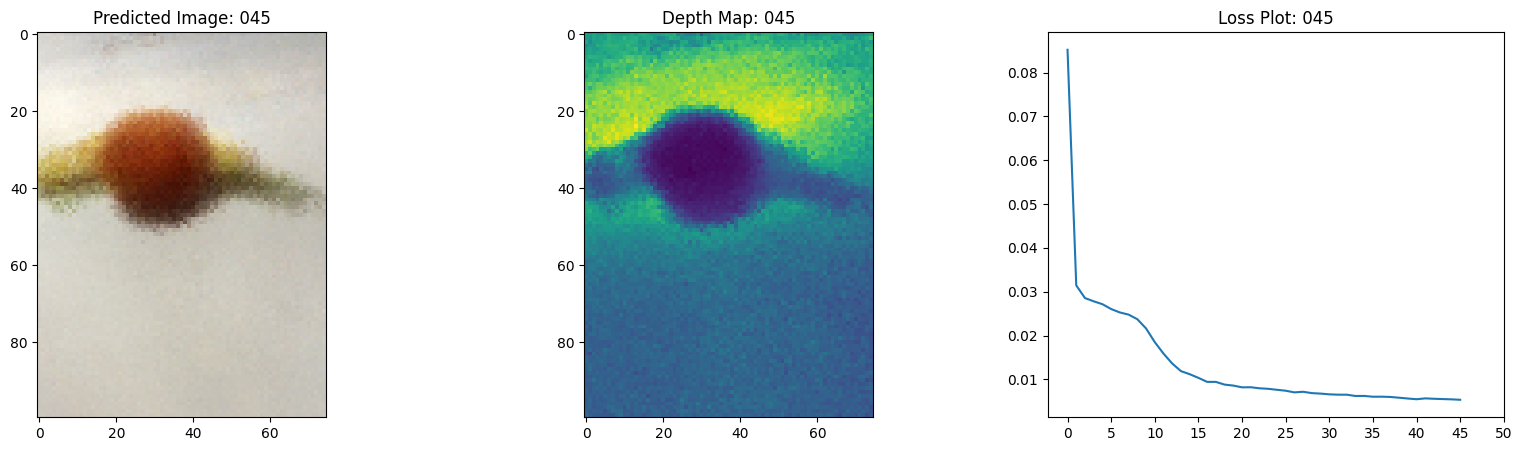

12/12 [==============================] - 22s 2s/step - loss: 0.0053 - psnr: 23.0634 - val_loss: 0.0046 - val_psnr: 23.4365
Epoch 47/50
1/1 [==============================] - 1s 678ms/step


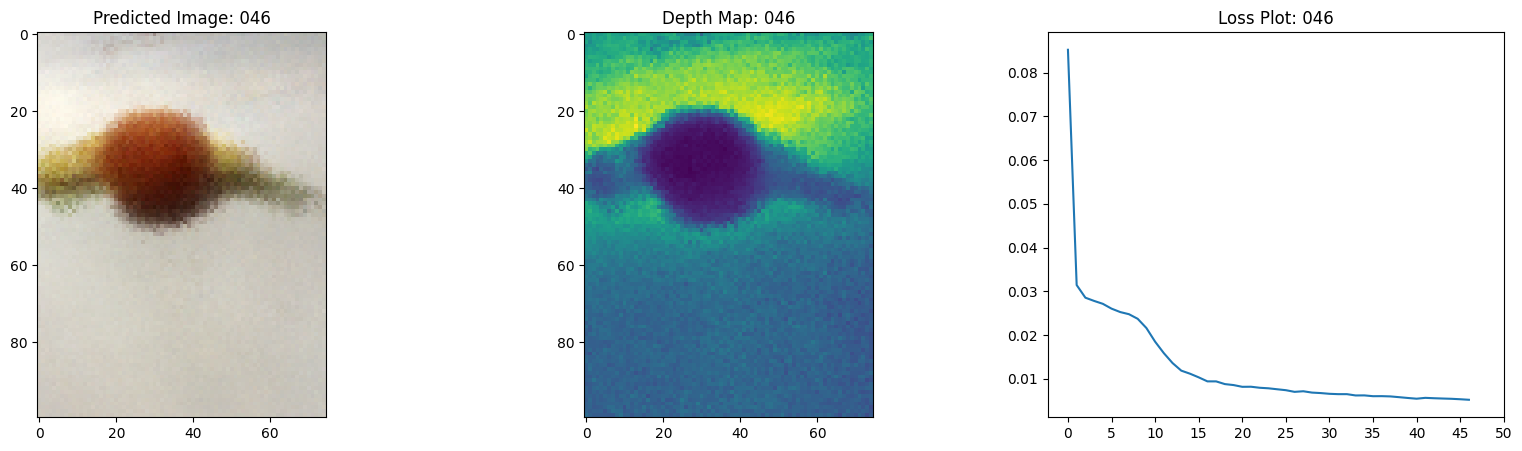

12/12 [==============================] - 22s 2s/step - loss: 0.0052 - psnr: 23.1732 - val_loss: 0.0044 - val_psnr: 23.6135
Epoch 48/50
1/1 [==============================] - 1s 548ms/step


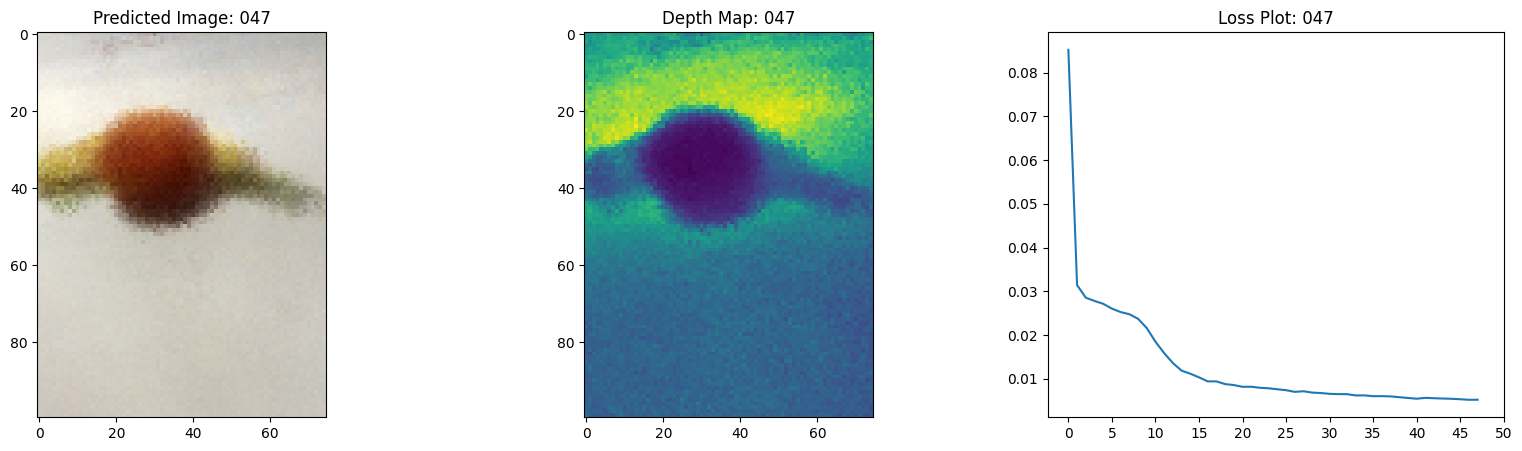

12/12 [==============================] - 21s 2s/step - loss: 0.0052 - psnr: 23.1520 - val_loss: 0.0045 - val_psnr: 23.4951
Epoch 49/50
1/1 [==============================] - 1s 561ms/step


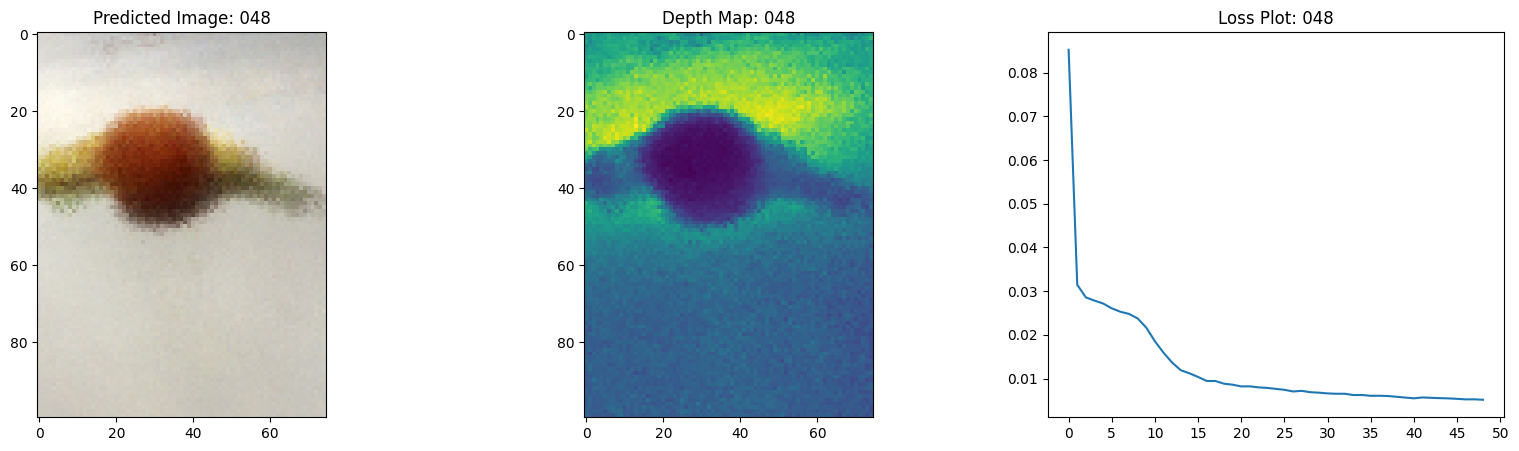

12/12 [==============================] - 22s 2s/step - loss: 0.0051 - psnr: 23.2422 - val_loss: 0.0043 - val_psnr: 23.7560
Epoch 50/50
1/1 [==============================] - 1s 552ms/step


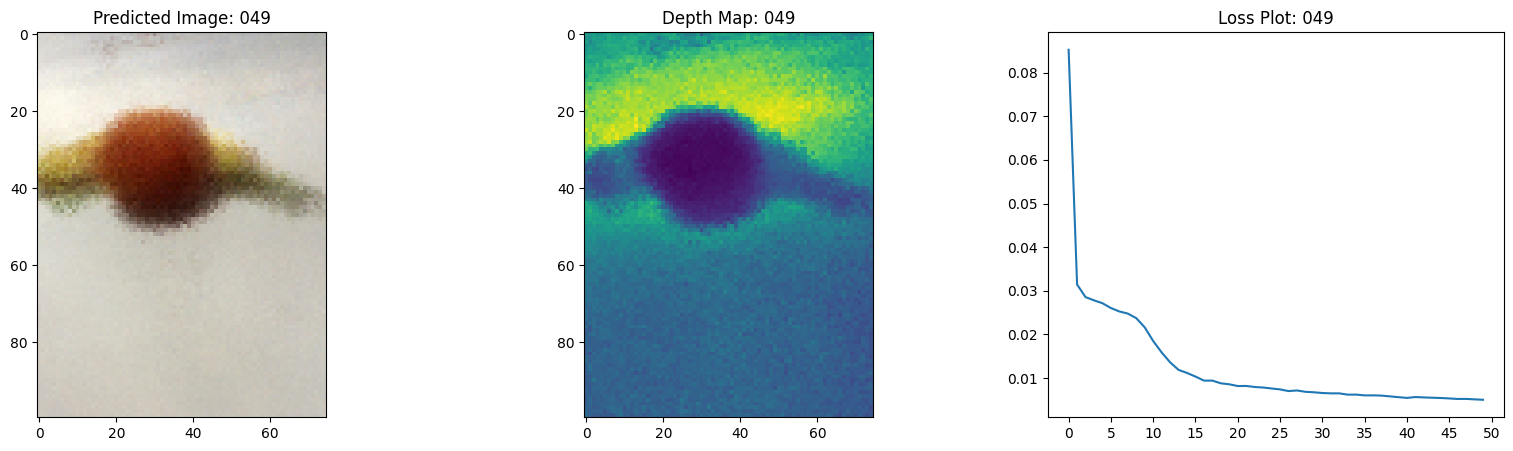

12/12 [==============================] - 22s 2s/step - loss: 0.0050 - psnr: 23.3398 - val_loss: 0.0047 - val_psnr: 23.3679


In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)

In [ ]:
def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


In [ ]:
create_gif("images/*.png", "training_newfruit_50.gif")

100%|██████████| 50/50 [00:01<00:00, 45.82it/s]


1/1 [==============================] - 1s 593ms/step


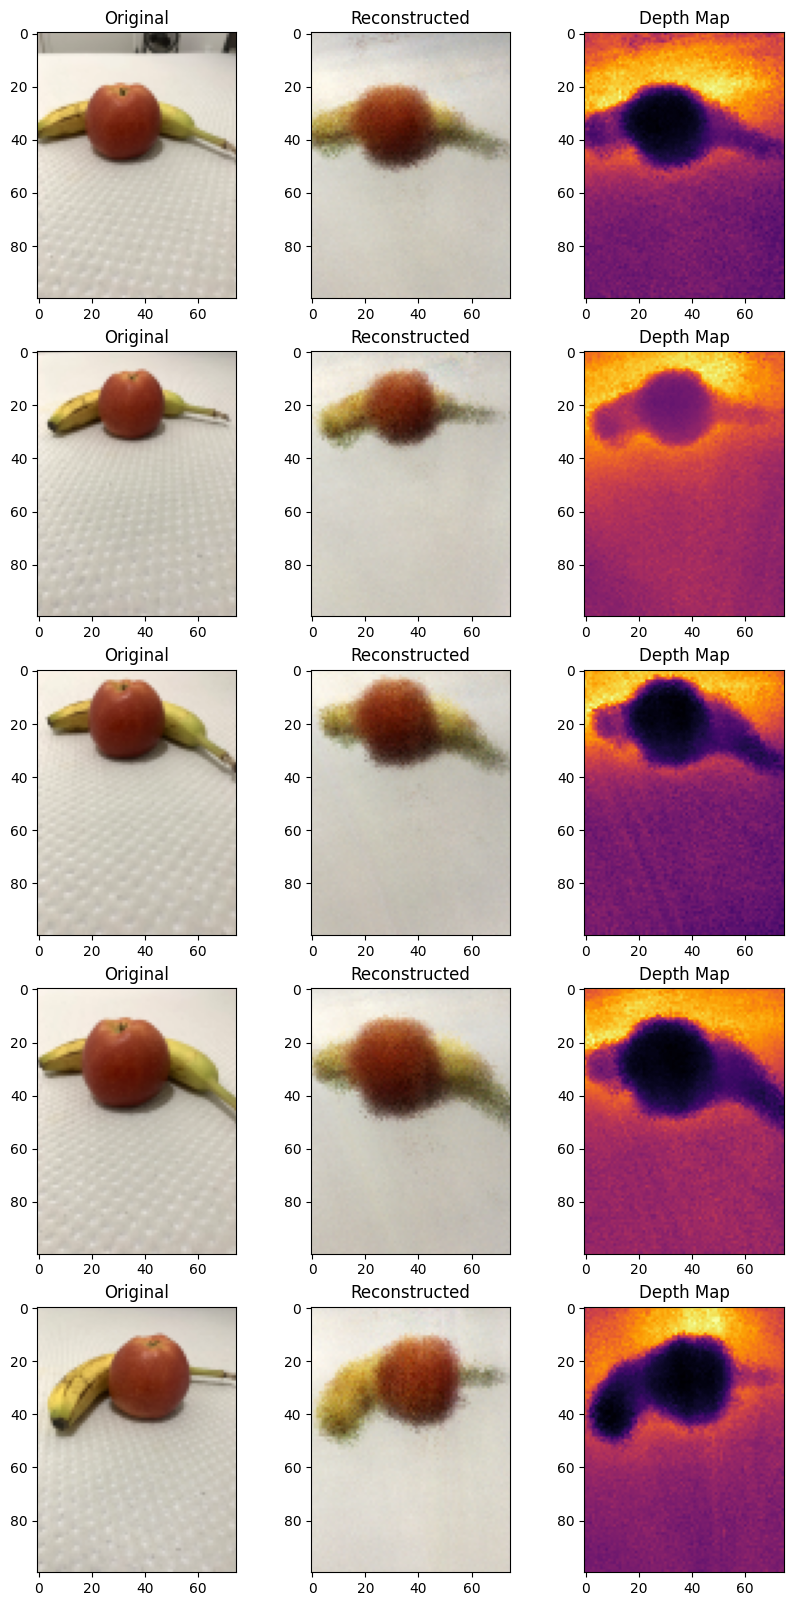

In [ ]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [ ]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

In [ ]:
rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video_newfruitx.gif"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

4it [00:00, 38.80it/s]

1/1 [==============================] - 1s 679ms/step


8it [00:01,  4.99it/s]

5
1/1 [==============================] - 1s 654ms/step


11it [00:03,  2.74it/s]

5
1/1 [==============================] - 1s 560ms/step


16it [00:04,  3.37it/s]

5
1/1 [==============================] - 1s 560ms/step


21it [00:05,  3.78it/s]

5
1/1 [==============================] - 1s 559ms/step


26it [00:06,  4.05it/s]

5
1/1 [==============================] - 1s 594ms/step


31it [00:07,  4.21it/s]

5
1/1 [==============================] - 1s 564ms/step


36it [00:08,  4.04it/s]

5
1/1 [==============================] - 1s 576ms/step


41it [00:10,  4.17it/s]

5
1/1 [==============================] - 1s 559ms/step


46it [00:11,  4.32it/s]

5
1/1 [==============================] - 1s 553ms/step


51it [00:12,  4.41it/s]

5
1/1 [==============================] - 1s 634ms/step


60it [00:13,  5.66it/s]

5
1/1 [==============================] - 1s 638ms/step


62it [00:14,  4.10it/s]

5
1/1 [==============================] - 1s 563ms/step


66it [00:15,  3.82it/s]

5
1/1 [==============================] - 1s 629ms/step


71it [00:17,  3.39it/s]

5
1/1 [==============================] - 1s 765ms/step


76it [00:19,  3.54it/s]

5
1/1 [==============================] - 1s 555ms/step


81it [00:20,  3.64it/s]

5
1/1 [==============================] - 1s 551ms/step


86it [00:21,  3.86it/s]

5
1/1 [==============================] - 1s 562ms/step


91it [00:22,  4.02it/s]

5
1/1 [==============================] - 1s 572ms/step


96it [00:23,  4.17it/s]

5
1/1 [==============================] - 1s 571ms/step


101it [00:24,  4.28it/s]

5
1/1 [==============================] - 1s 678ms/step


110it [00:26,  5.51it/s]

5
1/1 [==============================] - 1s 686ms/step


112it [00:27,  3.95it/s]

5
1/1 [==============================] - 1s 667ms/step


120it [00:29,  4.09it/s]

5
